# Initialization

In [152]:
import tables_io
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
import qp
import copy
from rail.core.stage import RailStage
from rail.raruma import utility_functions as raruma_util
from rail.raruma import plotting_functions as raruma_plot
from rail.raruma import admixture_functions as raruma_admix
from rail.raruma import wrapper_classes as raruma_wrap
from scipy.stats import sigmaclip
from astropy.stats import biweight_location, biweight_scale
import hashlib


In [153]:
import os

# pz_dir = '/global/cfs/cdirs/lsst/groups/PZ/DP1'  
# if that fails you can use this
# pz_dir = '/global/u2/e/echarles/dx'
#pz_dir = '/Users/echarles/pz'

# use user home directory
#pz_dir = os.path.expanduser('~')

# use user home directory plus additional folder
#pz_dir = os.path.expanduser('~') + '/pz'
pz_dir = os.path.expanduser('~') + '/dev'

print("pz_dir:",pz_dir)

pz_dir: /home/phoenix/dev


In [154]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

In [155]:
# load train and test data
train = tables_io.read(f"{pz_dir}/data/train/dp1_ecdfs_matched_specgold_train.hdf5")
test = tables_io.read(f"{pz_dir}/data/test/dp1_ecdfs_matched_specgold_test.hdf5")

#train = tables_io.read(f"{pz_dir}/data/train/dp1_matched_v4_train.hdf5")
#test = tables_io.read(f"{pz_dir}/data/test/dp1_matched_v4_test.hdf5")

#d.keys()
#train = tables_io.sliceObj(d, slice(0, -1, 10))
#test = tables_io.sliceObj(d, slice(1, -1, 10))

#model_dir = "/projects/dp1_v4/data/gold_baseline"
#model_dir = ''

In [156]:
from rail.estimation.algos.k_nearneigh import KNearNeighInformer, KNearNeighEstimator
from rail.utils.catalog_utils import RubinCatalogConfig

# Select the catalog/available columns
RubinCatalogConfig.apply("com_cam_gaap")

#band_names = raruma_util.make_band_names('LSST_obs_{band}', 'ugrizy')
#error_band_names = raruma_util.make_band_names('LSST_obs_{band}_err', 'ugrizy')

In [157]:
KNearNeighInformer.config_options.keys()

dict_keys(['output_mode', 'hdf5_groupname', 'zmin', 'zmax', 'nzbins', 'nondetect_val', 'mag_limits', 'bands', 'ref_band', 'redshift_col', 'trainfrac', 'seed', 'sigma_grid_min', 'sigma_grid_max', 'ngrid_sigma', 'leaf_size', 'nneigh_min', 'nneigh_max', 'only_colors'])

# Definitions

In [158]:
# astra ·₊✧ 12/2025 .⋆˚★ Uncertainty quantification
# Uncertainty extraction: calculates standard deviation of redshift PDFs
# Adapted from Plot_pdfs my_mean_std
#
#  Input: qp_dstn (qp.Ensemble object), grid (redshift grid array)
#  Output: Standard deviation for each PDF, shape (n_galaxies, 1)

def calc_std(qp_dstn, grid):
    pdfs = qp_dstn.pdf(grid)  # Get PDF values on grid
    norms = pdfs.sum(axis=1)  # Normalize
    means = np.sum(pdfs * grid, axis=1) / norms  # Calculate mean redshift
    diffs = (np.expand_dims(grid, -1) - means).T  # Distance from mean
    wt_diffs = diffs * diffs * pdfs  # Weighted squared differences
    stds = np.sqrt((wt_diffs).sum(axis=1)/norms)  # Standard deviation
    return np.expand_dims(stds, -1)

## smear_data

In [159]:
# Add Gaussian noise to magnitude measurements
#
#  Input: input_dict (dict from tables_io.read)
#         noise_levels (scalar for uniform noise OR array of length n_galaxies for per-galaxy noise)
#  Output: new dict with noisy magnitudes
#  Contributor: astra ·₊✧ 12/2025

def smear_data(input_dict, noise_levels):
    # Extract magnitude columns into 2D array (n_galaxies, 6)
    train_features = raruma_util.get_band_values(input_dict, '{band}_gaap1p0Mag', 'ugrizy')
    n_galaxies = train_features.shape[0]
    
    # Handle scalar vs per-galaxy noise input
    
    # If scalar noise_levels => Uniform noise across entire dataset
    if np.isscalar(noise_levels):
        noise_array = noise_levels * np.ones(n_galaxies)
        
    # If array of length n_galaxies => Apply per-galaxy noise
    elif isinstance(noise_levels, np.ndarray) and len(noise_levels) == n_galaxies:
        noise_array = noise_levels
        
    # Else (array of other length)
    else:
        raise ValueError(f"noise_levels must be scalar or array of length {n_galaxies}, got length {len(noise_levels)}")
    
    # Add Gaussian noise - gaussian_noise expects (n_bands, n_galaxies) input, performs a transpose
    noisy_mags = raruma_admix.gaussian_noise(train_features.T, noise_levels=noise_array)

    # Create output dictionary (copy input to preserve original)
    output_dict = copy.deepcopy(input_dict)
    
    # Write noisy magnitudes into output dictionary
    for i, band in enumerate('ugrizy'):
        output_dict[f'{band}_gaap1p0Mag'] = noisy_mags[:, i]
    
    return output_dict

## create_mixed_noise_data

In [160]:
# Create heterogeneous training set with varying noise levels assigned randomly
#
#  Input: data (dict), noise_levels (array of noise values)
#  Output: new dict with heterogeneous noise applied, array of per-galaxy noise levels
#  Contributor: astra ·₊✧ 12/2025

def create_mixed_noise_data(data, noise_levels):
    n_galaxies = len(data['redshift'])
    n_levels = len(noise_levels)
    
    # Randomly assign each galaxy to a noise level
    noise_assignments = np.random.choice(n_levels, size=n_galaxies)
    
    # Build per-galaxy noise array based on random noise level assignments
    per_galaxy_noise = noise_levels[noise_assignments]
     
    # Apply noise using smear_data with per-galaxy noise array
    noisy_data = smear_data(data, per_galaxy_noise)
    return noisy_data, per_galaxy_noise


In [161]:
# astra ·₊✧ 12/2025 .⋆˚★ Test smear_data and create_mixed_noise_data to ensure noise was applied appropriately

# ---- Test: smear_data ----

#np.random.seed(42)
test_dict = {'redshift': train['redshift'][:1000]}
for band in 'ugrizy':
    test_dict[f'{band}_gaap1p0Mag'] = train[f'{band}_gaap1p0Mag'][:1000].copy()

test_original = test_dict['u_gaap1p0Mag'].copy()
test_noisy = smear_data(test_dict, 0.2)
differences = test_noisy['u_gaap1p0Mag'] - test_original
std_actual = np.std(differences)
pass_test = abs(std_actual - 0.2) < 0.05
print(f"★ Uniform noise test: {'PASS' if pass_test else 'FAIL'} (std={std_actual:.4f}, expect 0.2±0.05)")

# ---- Test: create_mixed_noise_data ----

noise_grid_test = np.array([0.01, 0.1, 0.5])
test_original_mix = test_dict['u_gaap1p0Mag'].copy()

# Apply mixed noise

test_mixed, test_noise_assignments = create_mixed_noise_data(test_dict, noise_grid_test)
#test_mixed = create_mixed_noise_data(test_dict, noise_grid_test)
differences_mixed = test_mixed['u_gaap1p0Mag'] - test_original_mix

# Calculate statistics
median_diff = np.median(differences_mixed)
std_diff = np.std(differences_mixed)

# Expected std: weighted average of noise levels (assuming equal distribution)
# ~1/3 get 0.01, ~1/3 get 0.1, ~1/3 get 0.5
# Expected combined std ≈ sqrt((0.01^2 + 0.1^2 + 0.5^2)/3) ≈ 0.29
std_expected = np.sqrt(np.mean(noise_grid_test**2))

pass_mixed = (abs(median_diff) < 0.05) and (abs(std_diff - std_expected) < 0.1)
print(f"★ Mixed noise test: {'PASS' if pass_mixed else 'FAIL'} (std={std_diff:.4f}, expect ~{std_expected:.2f})")

★ Uniform noise test: PASS (std=0.1960, expect 0.2±0.05)
★ Mixed noise test: PASS (std=0.3015, expect ~0.29)


## degrade_data

In [162]:
# Apply data degradation
#
#  Input: input_dict (dict from tables_io.read)
#        degradation_type (str): 'magnitude_uniform', 'magnitude_mixed', 
#                               'redshift_random', 'redshift_break'
#        **params: degradation-specific parameters
#          - For magnitude_uniform: noise_level (scalar)
#          - For magnitude_mixed: noise_levels (array)
#          - For redshift_random: frac (fraction to degrade)
#          - For redshift_break: frac, mag_cutoff, shift_amount
#  Output: Modified copy with degraded data, original unchanged
#  Contributor: astra ·₊✧ 01/2026
def degrade_data(input_dict, degradation_type, **params):
    
    # If magnitude degradation with uniform noise
    if degradation_type == 'magnitude_uniform':
        # Apply uniform Gaussian noise to all galaxies
        return smear_data(input_dict, params['noise_level']), {}
    
    # If magnitude degradation with mixed noise levels
    elif degradation_type == 'magnitude_mixed':
        # Apply heterogeneous noise across training set
        output_dict, per_galaxy_noise = create_mixed_noise_data(input_dict, params['noise_levels'])
        return output_dict, {'per_galaxy_noise': per_galaxy_noise}
    
    # If random redshift degradation
    elif degradation_type == 'redshift_random':
        # Randomly select fraction of redshifts and replace with random values
        frac = params.get('frac', 0.01)
        output_dict = copy.deepcopy(input_dict)
        n_galaxies = len(output_dict['redshift'])
        n_degrade = int(frac * n_galaxies)
        degrade_indices = np.random.choice(n_galaxies, n_degrade, replace=False)
        z_min, z_max = output_dict['redshift'].min(), output_dict['redshift'].max()
        output_dict['redshift'][degrade_indices] = np.random.uniform(z_min, z_max, n_degrade)
        return output_dict, {'degrade_indices': degrade_indices}
    
    # If systematic break confusion degradation
    elif degradation_type == 'redshift_break':
        # Apply systematic redshift shift to faint galaxies (Lyman/Balmer confusion)
        frac = params.get('frac', 0.01)
        mag_cutoff = params.get('mag_cutoff', 24.0)
        
        # Physical constants
        TRUE_WAVELEN = 3646.0  # Balmer break (Angstroms)
        WRONG_WAVELEN = 1216.0  # Lyman break (Angstroms)
        
        output_dict = copy.deepcopy(input_dict)
        n_galaxies = len(output_dict['redshift'])
        
        # Minimum redshift threshold: confusion formula could produce negative (unphysical) redshifts if z_true is too low
        zmin = WRONG_WAVELEN / TRUE_WAVELEN - 1
        
        # Select faint galaxies (i-band magnitude > cutoff) AND above zmin (only degrade galaxies above zmin to ensure transformed redshifts remain positive)
        faint_mask = (output_dict['i_gaap1p0Mag'] > mag_cutoff) & (output_dict['redshift'] > zmin)
        n_faint = faint_mask.sum()
        
        # If eligible faint galaxies exist
        if n_faint > 0:
            # Select fraction of eligible faint galaxies to degrade
            n_degrade = int(frac * n_faint)
            faint_indices = np.where(faint_mask)[0]
            degrade_indices = np.random.choice(faint_indices, n_degrade, replace=False)
            
            # Apply break confusion transformation
            z_true = output_dict['redshift'][degrade_indices]
            z_confused = (1 + z_true) * TRUE_WAVELEN / WRONG_WAVELEN - 1
            output_dict['redshift'][degrade_indices] = z_confused
            
            return output_dict, {'degrade_indices': degrade_indices, 'n_faint': n_faint, 'zmin': zmin}
        
        # Else (no eligible faint galaxies)
        else:
            return output_dict, {'degrade_indices': np.array([]), 'n_faint': 0, 'zmin': zmin}
    
    # Else (invalid degradation type)
    else:
        raise ValueError(f"Unknown degradation_type: {degradation_type}")

# Ref
# https://github.com/LSSTDESC/rail_astro_tools/blob/005245a6dd6124fcd41c9159424066b3b0f805fb/src/rail/creation/degraders/spectroscopic_degraders.py#L55

In [163]:
# astra ·₊✧ 12/2025 .⋆˚★ Test degrade_data function for all degradation types
#
# Tests: (1) magnitude_uniform, (2) magnitude_mixed, (3) redshift_random
# Verifies data is actually modified and metadata is returned correctly

# Setup test data
np.random.seed(42)
test_dict = {'redshift': train['redshift'][:1000].copy()}
for band in 'ugrizy':
    test_dict[f'{band}_gaap1p0Mag'] = train[f'{band}_gaap1p0Mag'][:1000].copy()

print("=" * 60)
print("DEGRADE_DATA FUNCTION TESTS")
print("=" * 60)

# ---- Test 1: magnitude_uniform ----
print("\n[TEST 1] magnitude_uniform with noise_level=0.2")
test_original_u = test_dict['u_gaap1p0Mag'].copy()
test_uniform, metadata_uniform = degrade_data(test_dict, 'magnitude_uniform', noise_level=0.2)
differences_uniform = test_uniform['u_gaap1p0Mag'] - test_original_u
std_uniform = np.std(differences_uniform)
pass_magnitude_uniform = abs(std_uniform - 0.2) < 0.05
print(f"  Std of differences: {std_uniform:.4f} (expect 0.2±0.05)")
print(f"  Metadata returned: {metadata_uniform}")
print(f"  Result: {'PASS' if pass_magnitude_uniform else 'FAIL'}")

# ---- Test 2: magnitude_mixed ----
print("\n[TEST 2] magnitude_mixed with noise_levels=[0.01, 0.1, 0.5]")
noise_levels_test = np.array([0.01, 0.1, 0.5])
test_original_u2 = test_dict['u_gaap1p0Mag'].copy()
test_mixed, metadata_mixed = degrade_data(test_dict, 'magnitude_mixed', noise_levels=noise_levels_test)
differences_mixed = test_mixed['u_gaap1p0Mag'] - test_original_u2
std_mixed = np.std(differences_mixed)
std_expected = np.sqrt(np.mean(noise_levels_test**2))
has_metadata = 'per_galaxy_noise' in metadata_mixed
metadata_length = len(metadata_mixed['per_galaxy_noise']) if has_metadata else 0
pass_magnitude_mixed = (abs(std_mixed - std_expected) < 0.1) and (metadata_length == 1000)
print(f"  Std of differences: {std_mixed:.4f} (expect ~{std_expected:.2f})")
print(f"  Metadata contains per_galaxy_noise: {has_metadata}")
print(f"  Metadata array length: {metadata_length} (expect 1000)")
print(f"  Result: {'PASS' if pass_magnitude_mixed else 'FAIL'}")

# ---- Test 3: redshift_random with default frac ----
print("\n[TEST 3] redshift_random with default frac=0.01")
test_original_z = test_dict['redshift'].copy()
test_redshift_default, metadata_redshift_default = degrade_data(test_dict, 'redshift_random')
differences_z = (test_redshift_default['redshift'] != test_original_z)
n_degraded_default = differences_z.sum()
expected_degraded_default = int(0.01 * 1000)
has_indices = 'degrade_indices' in metadata_redshift_default
pass_redshift_defaultfrac = (abs(n_degraded_default - expected_degraded_default) <= 2) and has_indices
print(f"  Galaxies degraded: {n_degraded_default} (expect ~{expected_degraded_default})")
print(f"  Metadata contains degrade_indices: {has_indices}")
print(f"  Result: {'PASS' if pass_redshift_defaultfrac else 'FAIL'}")

# ---- Test 4: redshift_random with explicit frac ----
print("\n[TEST 4] redshift_random with explicit frac=0.05")
test_original_z2 = test_dict['redshift'].copy()
test_redshift_explicit, metadata_redshift_explicit = degrade_data(test_dict, 'redshift_random', frac=0.05)
differences_z2 = (test_redshift_explicit['redshift'] != test_original_z2)
n_degraded_explicit = differences_z2.sum()
expected_degraded_explicit = int(0.05 * 1000)
pass_redshift_customfrac = abs(n_degraded_explicit - expected_degraded_explicit) <= 3
print(f"  Galaxies degraded: {n_degraded_explicit} (expect ~{expected_degraded_explicit})")
print(f"  Metadata indices length: {len(metadata_redshift_explicit['degrade_indices'])}")
print(f"  Result: {'PASS' if pass_redshift_customfrac else 'FAIL'}")

# ---- Test 5: redshift_break ----
print("\n[TEST 5] redshift_break with default frac=0.01, mag_cutoff=24.0")
test_original_z5 = test_dict['redshift'].copy()
test_break, metadata_break = degrade_data(test_dict, 'redshift_break')

# Check how many were degraded
n_degraded = (test_break['redshift'] != test_original_z5).sum()
print(f"  Galaxies degraded: {n_degraded}")
print(f"  Metadata zmin: {metadata_break.get('zmin', 'N/A'):.3f}")

# Verify transformation formula on first degraded galaxy
if n_degraded > 0:
    idx = metadata_break['degrade_indices'][0]
    z_before = test_original_z5[idx]
    z_after = test_break['redshift'][idx]
    z_expected = (1 + z_before) * 3646.0 / 1216.0 - 1
    formula_correct = abs(z_after - z_expected) < 1e-6
    pass_redshift_break = formula_correct
    print(f"  Formula check: z={z_before:.3f} → {z_after:.3f} (expect {z_expected:.3f}): {'PASS' if formula_correct else 'FAIL'}")
else:
    pass_redshift_break = False
    print(f"  Result: SKIP (no eligible galaxies)")

# ---- Summary ----
print("\n" + "=" * 60)
all_pass = pass_magnitude_uniform and pass_magnitude_mixed and pass_redshift_defaultfrac and pass_redshift_customfrac and pass_redshift_break
print(f"OVERALL: {'ALL TESTS PASSED' if all_pass else 'SOME TESTS FAILED'}")
print("=" * 60)

DEGRADE_DATA FUNCTION TESTS

[TEST 1] magnitude_uniform with noise_level=0.2
  Std of differences: 0.1927 (expect 0.2±0.05)
  Metadata returned: {}
  Result: PASS

[TEST 2] magnitude_mixed with noise_levels=[0.01, 0.1, 0.5]
  Std of differences: 0.3198 (expect ~0.29)
  Metadata contains per_galaxy_noise: True
  Metadata array length: 1000 (expect 1000)
  Result: PASS

[TEST 3] redshift_random with default frac=0.01
  Galaxies degraded: 10 (expect ~10)
  Metadata contains degrade_indices: True
  Result: PASS

[TEST 4] redshift_random with explicit frac=0.05
  Galaxies degraded: 50 (expect ~50)
  Metadata indices length: 50
  Result: PASS

[TEST 5] redshift_break with default frac=0.01, mag_cutoff=24.0
  Galaxies degraded: 3
  Metadata zmin: -0.666
  Formula check: z=2.024 → 8.067 (expect 8.067): PASS

OVERALL: ALL TESTS PASSED


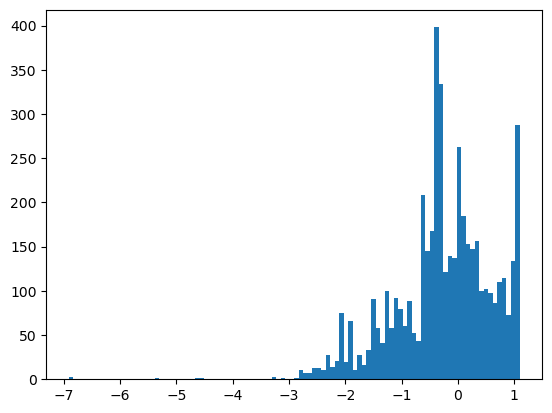

In [164]:
_ = plt.hist(np.log(train['redshift'].clip(1e-3, 3)), bins=100)

## train_test_uncertainty

In [165]:
# Train model, test it, and extract uncertainty for any algorithm
#
#  Input: train_data (dict), test_data (dict), z_grid (array), 
#         informer_class (e.g., KNearNeighInformer), estimator_class (e.g., KNearNeighEstimator),
#         informer_kwargs (dict of params for informer), estimator_kwargs (dict of params for estimator),
#         label (str, identifier for output file, default 'output')
#  Output: uncertainty array (n_test_galaxies, 1), estimate_handle
#  Contributor: astra ·₊✧ 12/2025

def train_test_uncertainty(train_data, test_data, z_grid, informer_class, estimator_class, 
                          informer_kwargs=None, estimator_kwargs=None, label='output'):
    if informer_kwargs is None:
        informer_kwargs = {}
    if estimator_kwargs is None:
        estimator_kwargs = {}

    DS.clear()  # Clear DataStore to avoid conflicts

    # Debugging: Delete the model file if it already exists
    #print(f"Model file exists before training: {os.path.exists(f'{label}_model.pkl')}")
    if os.path.exists(f'{label}_model.pkl'):
        os.remove(f'{label}_model.pkl')
        print(f"Deleted existing {label}_model.pkl")

    # Debugging: check DataStore contents before proceeding
    #print(f"\n[{label}] DataStore contents before inform: {list(DS.keys())}")
    #if 'input' in DS.keys():
    #    stored_input = DS['input'].data
    #    print(f"[{label}] DataStore already has input data, first u-mag: {stored_input['u_gaap1p0Mag'][0]}")
    
    # Train model

    # Debugging: Verify training data is different between runs
    #print(f"About to train with label '{label}'")
    #print(f"First galaxy u-band mag: {train_data['u_gaap1p0Mag'][0]}")
    #print(f"Training data object id: {id(train_data)}")

    RailStage.data_store.clear()      
    informer = informer_class.make_stage(model=f'{label}_model.pkl', **informer_kwargs)
    model = informer.inform(train_data)

    # Debugging: Info to compare the created model
    #print(f"Model object ID: {id(model)}")
    #print(f"Model file hash: {hashlib.md5(open(model.path, 'rb').read()).hexdigest()}")
    #print(f"Model type: {type(model)}")
    #print(f"Model path: {model.path if hasattr(model, 'path') else 'N/A'}")
    #print(f"Does model file exist? {os.path.exists(f'{label}_model.pkl')}")
    #if os.path.exists(f'{label}_model.pkl'):
    #    print(f"File size: {os.path.getsize(f'{label}_model.pkl')}")
    #print(f"Model in DataStore: {model in DS.values() if hasattr(DS, 'values') else 'N/A'}")
    
    # Test model
    estimator = estimator_class.make_stage(model=model, output=f'{label}_output.hdf5', **estimator_kwargs)
    estimate_handle = estimator.estimate(test_data)
    
    # Extract PDFs and calculate uncertainty
    ensemble = qp.read(estimate_handle.path)
    uncertainty = calc_std(ensemble, z_grid)
    
    return uncertainty, estimate_handle

In [166]:
# Calculate photo-z performance metrics binned by redshift
#
#  Input: estimate_handle (output from train_test_uncertainty)
#        z_bins (array of bin edges for spectroscopic redshift)
#  Output: bin_centers, sigma_array, bias_array, outlier_rate_array
#  Contributor: astra ·₊✧ 01/2026

def calc_photoz_performance_metrics(estimate_handle, z_bins):
    # Extract redshifts
    z_spec = estimate_handle.data.ancil['redshift']
    z_phot = estimate_handle.data.ancil['zmode'].flatten()
    
    # Calculate normalized residuals
    delta_z = (z_phot - z_spec) / (1 + z_spec)
    
    # Initialize output arrays
    n_bins = len(z_bins) - 1
    bin_centers = (z_bins[:-1] + z_bins[1:]) / 2
    sigma_array = np.zeros(n_bins)
    bias_array = np.zeros(n_bins)
    outlier_rate_array = np.zeros(n_bins)
    
    # Calculate metrics for each bin
    for i in range(n_bins):
        mask = (z_spec >= z_bins[i]) & (z_spec < z_bins[i+1])
        n_in_bin = mask.sum()
        
        # If bin has galaxies
        if n_in_bin > 0:
            delta_z_bin = delta_z[mask]
            sigma_array[i] = np.std(delta_z_bin)
            bias_array[i] = np.mean(delta_z_bin)
            outlier_rate_array[i] = (np.abs(delta_z_bin) > 0.15).sum() / n_in_bin
        # Else (empty bin)
        else:
            sigma_array[i] = np.nan
            bias_array[i] = np.nan
            outlier_rate_array[i] = np.nan
    
    return bin_centers, sigma_array, bias_array, outlier_rate_array

# Train and Test

## Baseline

In [167]:
# astra ·₊✧ 12/2025 .⋆˚★ Define noise parameters and establish baseline on clean data

noise_grid = np.logspace(-4, 0, 17) # Magnitudes of noise levels
z_grid = np.linspace(0., 4., 401)  # Redshift grid for PDF evaluation 

# Store estimates and uncertainties by case type
estimates = {}
uncertainties = {}

# Train and test on clean data using KNN
uncertainties['baseline'], estimates['baseline'] = train_test_uncertainty(
    train, test, z_grid,
    KNearNeighInformer, KNearNeighEstimator,
    informer_kwargs={'nondetect_val': np.nan},
    label='baseline'
)

print(f"★ Baseline uncertainty: median={np.median(uncertainties['baseline']):.4f}, mean={np.mean(uncertainties['baseline']):.4f}")

Deleted existing baseline_model.pkl
Inserting handle into data store.  input: None, KNearNeighInformer
split into 3602 training and 1201 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.03166666666666667 and numneigh=7



Inserting handle into data store.  model: inprogress_baseline_model.pkl, KNearNeighInformer
Process 0 running estimator on chunk 0 - 1,201
Process 0 estimating PZ PDF for rows 0 - 1,201
Inserting handle into data store.  output: inprogress_baseline_output.hdf5, KNearNeighEstimator
★ Baseline uncertainty: median=0.1700, mean=0.3356


## Configuration

In [168]:
# astra ·₊✧ 12/2025 .⋆˚★ Algorithm configuration

uncertainty_ratios = []
noise_levels_tested = []

algo_informer = KNearNeighInformer
algo_estimator = KNearNeighEstimator
algo_kwargs = {'nondetect_val': np.nan}

## Magnitude Cases

In [185]:
# astra ·₊✧ 01/2026 .⋆˚★ Perform training and testing for noisy magnitude cases 

# CASE 1: Train on magnitudes with mixed levels of noise
print("\n" + "="*60)
print("CASE 1: Magnitudes with mixed levels of noise")
print("="*60)
train_mag_mixed, metadata_train_mixed = degrade_data(copy.deepcopy(train), 'magnitude_mixed', noise_levels=noise_grid)
test_mag_mixed, metadata_test_mixed = degrade_data(copy.deepcopy(test), 'magnitude_mixed', noise_levels=noise_grid)
train_noise_levels_mixed = metadata_train_mixed['per_galaxy_noise']
test_noise_levels_mixed = metadata_test_mixed['per_galaxy_noise']

# Debugging: Verify data is actually noisy
#print(f"Original train u-band first 3: {train['u_gaap1p0Mag'][:3]}")
#print(f"Noisy train u-band first 3: {train_mag_mixed['u_gaap1p0Mag'][:3]}")
#print(f"Original test u-band first 3: {test['u_gaap1p0Mag'][:3]}")
#print(f"Noisy test u-band first 3: {test_mag_mixed['u_gaap1p0Mag'][:3]}")

uncertainties['magnitude_mixed'], estimates['magnitude_mixed'] = train_test_uncertainty(
    train_mag_mixed, test_mag_mixed, z_grid,
    algo_informer, algo_estimator,
    informer_kwargs=algo_kwargs,
    label='magnitude_mixed'
)

# Calculate uncertainty ratio
ratio = np.median(uncertainties['magnitude_mixed'] / uncertainties['baseline'])
uncertainty_ratios.append(ratio)
noise_levels_tested.append("magnitude_mixed")
print(f"★ Mixed magnitude noise model uncertainty ratio: {ratio:.4f}")



# CASE 2: Train separate model for each noise level
print("\n" + "="*60)
print("CASE 2: Separate model trained for each uniform magnitude noise level")
print("="*60)


# Initialize storage for magnitude_uniform case (multiple noise levels)
estimates['magnitude_uniform'] = {}
uncertainties['magnitude_uniform'] = {}

for noise in noise_grid:
    print(f"\nProcessing noise level: {noise:.2f} mag")

    # Apply noise to both train and test data
    #train_mag_uniform = smear_data(copy.deepcopy(train), noise * np.ones(6))
    #test_mag_uniform = smear_data(copy.deepcopy(test), noise * np.ones(6))
    train_mag_uniform, _ = degrade_data(copy.deepcopy(train), 'magnitude_uniform', noise_level=noise)
    test_mag_uniform, _ = degrade_data(copy.deepcopy(test), 'magnitude_uniform', noise_level=noise)

    # Needs modifications to preserve the estimator for each model
    uncertainty_current, estimate_current = train_test_uncertainty(
        train_mag_uniform, test_mag_uniform, z_grid,
        algo_informer, algo_estimator,
        informer_kwargs=algo_kwargs,
        label='magnitude_uniform'
    )
        
    # Store results for this noise level
    estimates['magnitude_uniform'][noise] = estimate_current
    uncertainties['magnitude_uniform'][noise] = uncertainty_current

    # Calculate uncertainty ratios for each
    ratio = np.median(uncertainty_current / uncertainties['baseline'])
    uncertainty_ratios.append(ratio)
    noise_levels_tested.append(noise)
    print(f"★ Per magnitude noise level model uncertainty ratio: {ratio:.4f}")

# Debugging: Verify we're reading from the noisy file
#print(f"Magnitude mixed estimate loaded from: {estimates['magnitude_mixed'].path}")
#print(f"Magnitude mixed first 5 predictions: {estimates['magnitude_mixed'].data.ancil['zmode'][:5].flatten()}")
#print(f"Baseline estimate first 5 predictions: {estimates['baseline'].data.ancil['zmode'][:5].flatten()}")


CASE 1: Magnitudes with mixed levels of noise
Deleted existing magnitude_mixed_model.pkl
Inserting handle into data store.  input: None, KNearNeighInformer
split into 3602 training and 1201 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.04611111111111112 and numneigh=7



Inserting handle into data store.  model: inprogress_magnitude_mixed_model.pkl, KNearNeighInformer
Process 0 running estimator on chunk 0 - 1,201
Process 0 estimating PZ PDF for rows 0 - 1,201
Inserting handle into data store.  output: inprogress_magnitude_mixed_output.hdf5, KNearNeighEstimator
★ Mixed magnitude noise model uncertainty ratio: 1.2060

CASE 2: Separate model trained for each uniform magnitude noise level

Processing noise level: 0.00 mag
Deleted existing magnitude_uniform_model.pkl
Inserting handle into data store.  input: None, KNearNeighInformer
split into 3602 training and 1201 validation samples
finding best fit sigma and NNeigh...



best fit values are sigm

## Redshift Cases

In [170]:
# astra ·₊✧ 01/2026 .⋆˚★ Perform training and testing for degraded redshift cases 

# CASE 3: Train with random redshift degradation
print("\n" + "="*60)
print("CASE 3: Random redshift degradation")
print("="*60)

train_redshift_random, metadata_train_random = degrade_data(copy.deepcopy(train), 'redshift_random')
test_redshift_random, metadata_test_random = degrade_data(copy.deepcopy(test), 'redshift_random')

uncertainties['redshift_random'], estimates['redshift_random'] = train_test_uncertainty(
    train_redshift_random, test_redshift_random, z_grid,
    algo_informer, algo_estimator,
    informer_kwargs=algo_kwargs,
    label='redshift_random'
)

# Calculate uncertainty ratio
ratio = np.median(uncertainties['redshift_random'] / uncertainties['baseline'])
uncertainty_ratios.append(ratio)
noise_levels_tested.append("redshift_random")
print(f"★ Random redshift degradation uncertainty ratio: {ratio:.4f}")



# CASE 4: Train with data mimicking break confusion
print("\n" + "="*60)
print("CASE 4: Degrade redshifts due to Lyman/Balmer break confusion")
print("="*60)

train_redshift_break, metadata_train_break = degrade_data(copy.deepcopy(train), 'redshift_break')
test_redshift_break, metadata_test_break = degrade_data(copy.deepcopy(test), 'redshift_break')

uncertainties['redshift_break'], estimates['redshift_break'] = train_test_uncertainty(
    train_redshift_break, test_redshift_break, z_grid,
    algo_informer, algo_estimator,
    informer_kwargs=algo_kwargs,
    label='redshift_break'
)

# Calculate uncertainty ratio
ratio = np.median(uncertainties['redshift_break'] / uncertainties['baseline'])
uncertainty_ratios.append(ratio)
noise_levels_tested.append("redshift_break")
print(f"★ Degrade redshifts due to Lyman/Balmer break confusion uncertainty ratio: {ratio:.4f}")


CASE 3: Random redshift degradation
Deleted existing redshift_random_model.pkl
Inserting handle into data store.  input: None, KNearNeighInformer
split into 3602 training and 1201 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.03166666666666667 and numneigh=7



Inserting handle into data store.  model: inprogress_redshift_random_model.pkl, KNearNeighInformer
Process 0 running estimator on chunk 0 - 1,201
Process 0 estimating PZ PDF for rows 0 - 1,201
Inserting handle into data store.  output: inprogress_redshift_random_output.hdf5, KNearNeighEstimator
★ Random redshift degradation uncertainty ratio: 1.0000

CASE 4: Degrade redshifts due to Lyman/Balmer break confusion
Deleted existing redshift_break_model.pkl
Inserting handle into data store.  input: None, KNearNeighInformer
split into 3602 training and 1201 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.03166666666666667 and numneigh=7



Inserting handl

In [171]:
# Debugging CASE 3: Random redshift degradation
print("\n=== VERIFYING CASE 3: Random Redshift degradation ===")
print(f"Train galaxies degraded: {len(metadata_train_random['degrade_indices'])} out of {len(train['redshift'])}")
print(f"Test galaxies degraded: {len(metadata_test_random['degrade_indices'])} out of {len(test['redshift'])}")
if len(metadata_train_random['degrade_indices']) > 0:
    idx = metadata_train_random['degrade_indices'][0]
    print(f"Example train galaxy: original z={train['redshift'][idx]:.4f}, degraded z={train_redshift_random['redshift'][idx]:.4f}")
if len(metadata_test_random['degrade_indices']) > 0:
    idx = metadata_test_random['degrade_indices'][0]
    print(f"Example test galaxy: original z={test['redshift'][idx]:.4f}, degraded z={test_redshift_random['redshift'][idx]:.4f}")

print("\n=== VERIFYING CASE 4: Break Confusion ===")
print(f"Train faint galaxies eligible: {metadata_train_break.get('n_faint', 0)}")
print(f"Test faint galaxies eligible: {metadata_test_break.get('n_faint', 0)}")
print(f"zmin threshold: {metadata_train_break.get('zmin', 'N/A'):.4f}")
print(f"Train galaxies degraded: {len(metadata_train_break['degrade_indices'])}")
print(f"Test galaxies degraded: {len(metadata_test_break['degrade_indices'])}")
if len(metadata_train_break['degrade_indices']) > 0:
    idx = metadata_train_break['degrade_indices'][0]
    print(f"Example train galaxy: original z={train['redshift'][idx]:.4f}, degraded z={train_redshift_break['redshift'][idx]:.4f}")
if len(metadata_test_break['degrade_indices']) > 0:
    idx = metadata_test_break['degrade_indices'][0]
    print(f"Example test galaxy: original z={test['redshift'][idx]:.4f}, degraded z={test_redshift_break['redshift'][idx]:.4f}")


# Check if redshift predictions differ from baseline
print("\n=== Prediction Differences from Baseline ===")

# Random degradation
diff_random = estimates['redshift_random'].data.ancil['zmode'] != estimates['baseline'].data.ancil['zmode']
n_diff_random = diff_random.sum()
print(f"\nRandom degradation:")
print(f"  Predictions different from baseline: {n_diff_random} out of {len(diff_random)}")
if n_diff_random > 0:
    print(f"  Example differences:")
    diff_indices = np.where(diff_random)[0][:3]
    for idx in diff_indices:
        z_baseline = estimates['baseline'].data.ancil['zmode'][idx].item()
        z_random = estimates['redshift_random'].data.ancil['zmode'][idx].item()
        z_true = test['redshift'][idx]
        print(f"    Galaxy {idx}: baseline={z_baseline:.4f}, random={z_random:.4f}, true={z_true:.4f}")

# Break confusion
diff_break = estimates['redshift_break'].data.ancil['zmode'] != estimates['baseline'].data.ancil['zmode']
n_diff_break = diff_break.sum()
print(f"\nBreak confusion:")
print(f"  Predictions different from baseline: {n_diff_break} out of {len(diff_break)}")
if n_diff_break > 0:
    print(f"  Example differences:")
    diff_indices = np.where(diff_break)[0][:3]
    for idx in diff_indices:
        z_baseline = estimates['baseline'].data.ancil['zmode'][idx].item()
        z_break = estimates['redshift_break'].data.ancil['zmode'][idx].item()
        z_true = test['redshift'][idx]
        print(f"    Galaxy {idx}: baseline={z_baseline:.4f}, break={z_break:.4f}, true={z_true:.4f}")


=== VERIFYING CASE 3: Random Redshift degradation ===
Train galaxies degraded: 48 out of 4803
Test galaxies degraded: 12 out of 1201
Example train galaxy: original z=0.8640, degraded z=6.1317
Example test galaxy: original z=0.7260, degraded z=2.3795

=== VERIFYING CASE 4: Break Confusion ===
Train faint galaxies eligible: 1636
Test faint galaxies eligible: 424
zmin threshold: -0.6665
Train galaxies degraded: 16
Test galaxies degraded: 4
Example train galaxy: original z=1.3063, degraded z=5.9150
Example test galaxy: original z=1.2125, degraded z=5.6339

=== Prediction Differences from Baseline ===

Random degradation:
  Predictions different from baseline: 39 out of 1201
  Example differences:
    Galaxy 10: baseline=0.5300, random=0.5400, true=0.5433
    Galaxy 14: baseline=0.1300, random=0.1400, true=0.1281
    Galaxy 29: baseline=0.1200, random=0.1300, true=0.0824

Break confusion:
  Predictions different from baseline: 10 out of 1201
  Example differences:
    Galaxy 75: baseline=1

# Metrics

## Combined Plots

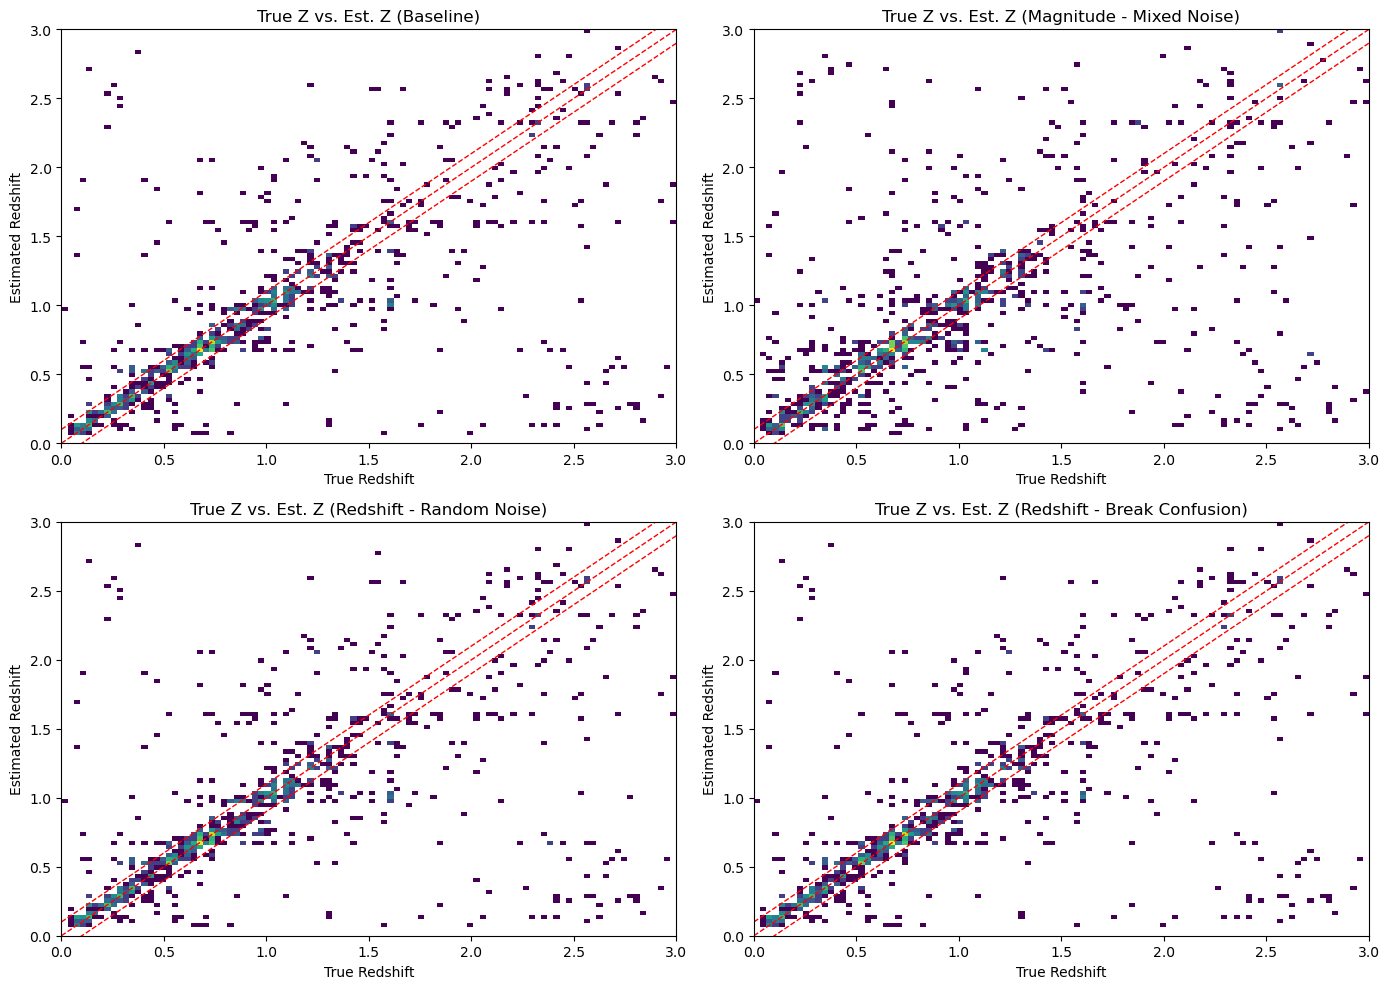

In [200]:
# astra ·₊✧ 02/2026 .⋆˚★ Create 2D histograms of true vs estimated redshift for all cases

# Define cases to plot
cases = [
    ('baseline', estimates['baseline'], 'Baseline'),
    ('magnitude_mixed', estimates['magnitude_mixed'], 'Magnitude - Mixed Noise'),
    ('redshift_random', estimates['redshift_random'], 'Redshift - Random Noise'),
    ('redshift_break', estimates['redshift_break'], 'Redshift - Break Confusion')
]

# Create subplot grid (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (label, estimate, title) in enumerate(cases):
    # Extract redshifts
    z_est = np.squeeze(estimate.data.ancil['zmode'])
    z_true = estimate.data.ancil['redshift']
    
    # Create 2D histogram
    axes[idx].hist2d(z_true, z_est, 
                     bins=(np.linspace(0., 3, 101), np.linspace(0., 3, 101)), 
                     norm='log')
    
    # Add reference lines
    z_range = np.linspace(0, 3, 100)
    axes[idx].plot(z_range, z_range, 'r--', linewidth=1)  # y=x
    axes[idx].plot(z_range, z_range + 0.1, 'r--', linewidth=1)  # +0.1
    axes[idx].plot(z_range, z_range - 0.1, 'r--', linewidth=1)  # -0.1
    
    axes[idx].set_ylabel('Estimated Redshift')
    axes[idx].set_xlabel('True Redshift')
    axes[idx].set_title(f'True Z vs. Est. Z ({title})')

plt.tight_layout()
plt.show()

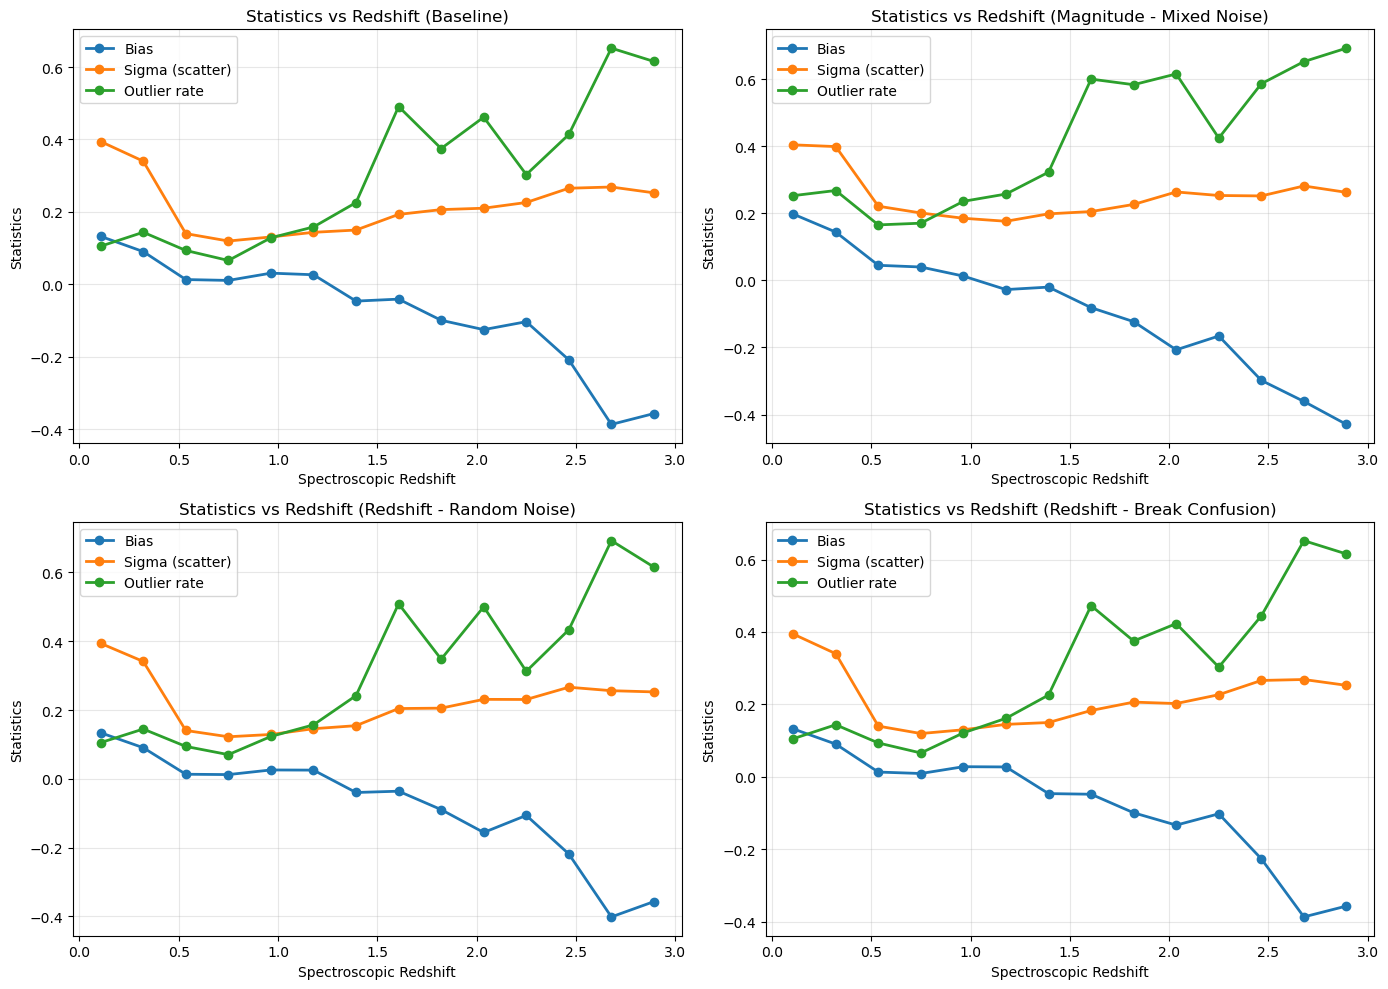

In [190]:
# astra ·₊✧ 02/2026 .⋆˚★ Calculate and plot statistics for all cases

# Create subplot grid (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

z_bins = np.linspace(0, 3, 15)  # 14 bins from 0 to 3

for idx, (label, estimate, title) in enumerate(cases):
    # Calculate metrics
    bin_centers, sigma, bias, outlier_rate = calc_photoz_performance_metrics(estimate, z_bins)
    
    # Plot statistics
    axes[idx].plot(bin_centers, bias, 'o-', label='Bias', linewidth=2)
    axes[idx].plot(bin_centers, sigma, 'o-', label='Sigma (scatter)', linewidth=2)
    axes[idx].plot(bin_centers, outlier_rate, 'o-', label='Outlier rate', linewidth=2)
    axes[idx].set_xlabel('Spectroscopic Redshift')
    axes[idx].set_ylabel('Statistics')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_title(f'Statistics vs Redshift ({title})')

plt.tight_layout()
plt.show()

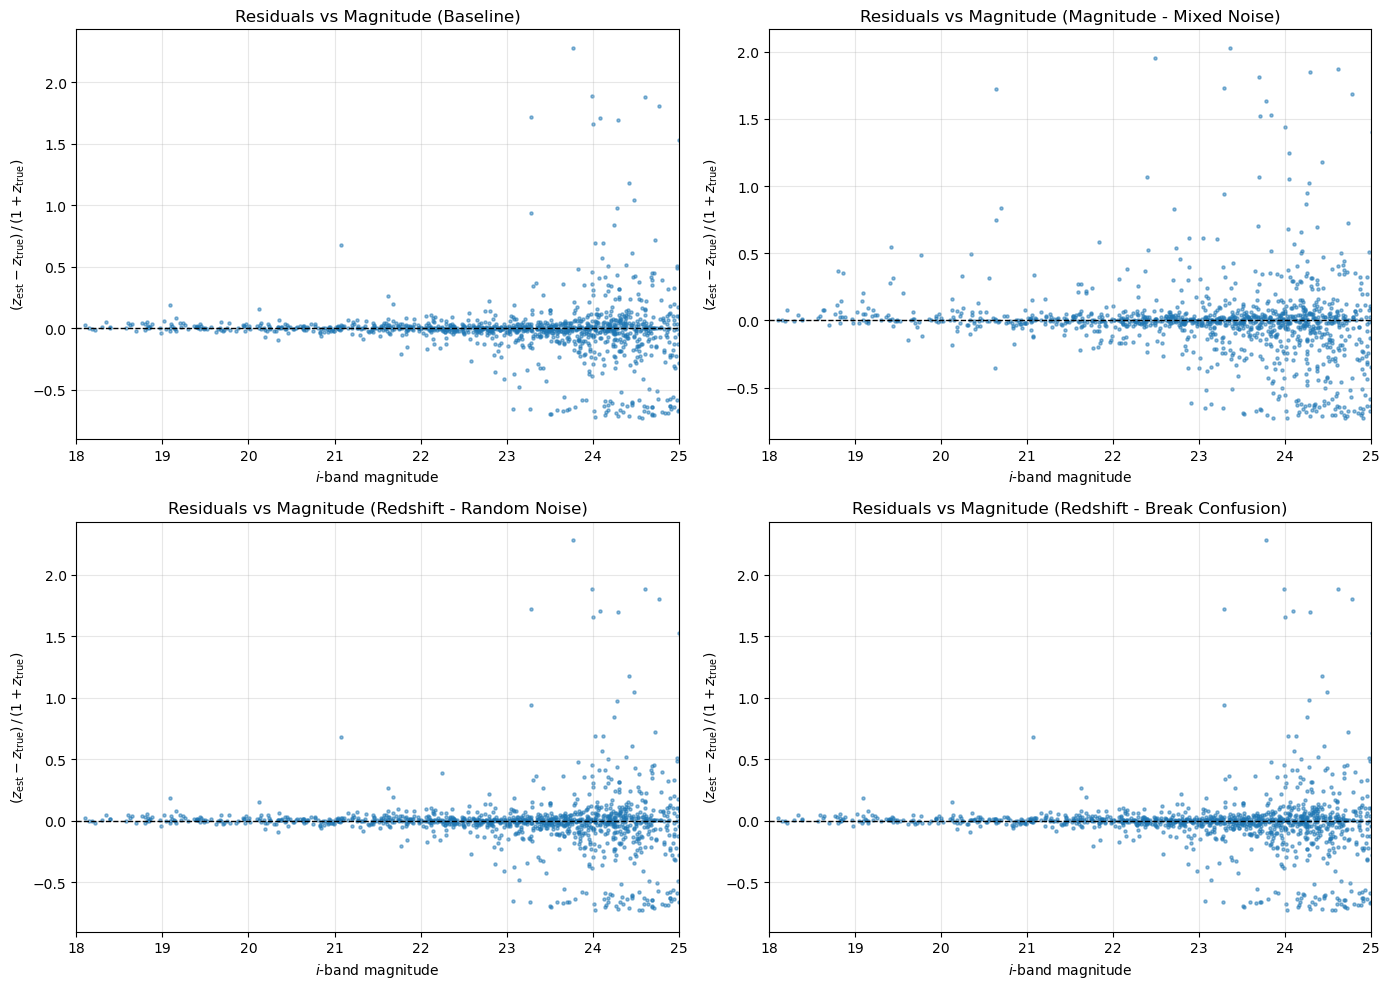

In [191]:
# astra ·₊✧ 02/2026 .⋆˚★ Create residual scatter plots vs i-band magnitude for all cases

# Extract i-band magnitude from test data
i_mag = test['i_gaap1p0Mag']

# Create subplot grid (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (label, estimate, title) in enumerate(cases):
    # Calculate normalized residuals
    z_est = estimate.data.ancil['zmode'].flatten()
    z_true = test['redshift']
    delta_z = (z_est - z_true) / (1 + z_true)
    
    # Create scatter plot
    axes[idx].scatter(i_mag, delta_z, alpha=0.5, s=5)    
    axes[idx].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[idx].set_xlabel(r'$i$-band magnitude')
    axes[idx].set_ylabel(r'$(z_{\mathrm{est}} - z_{\mathrm{true}}) \, / \, (1 + z_{\mathrm{true}})$')
    axes[idx].set_title(f'Residuals vs Magnitude ({title})')
    axes[idx].set_xlim(18, 25)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

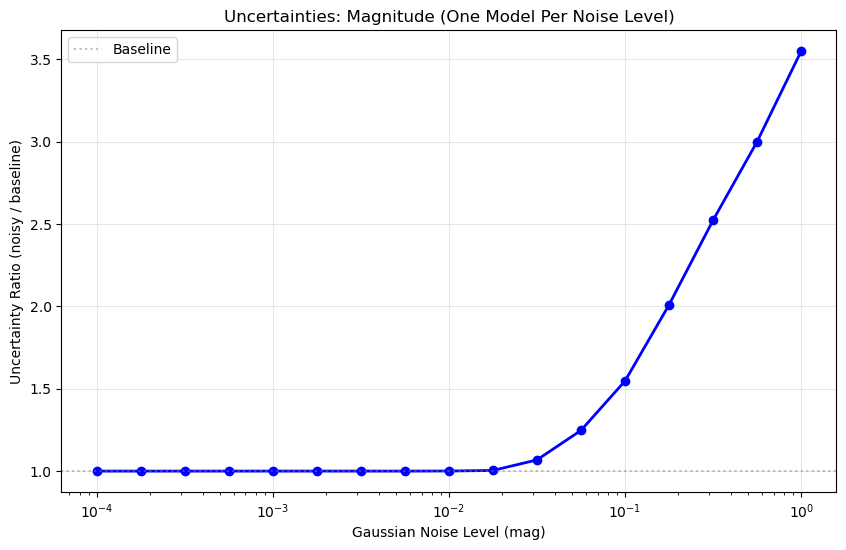

In [193]:
# astra ·₊✧ 02/2026 .⋆˚★ Plot uncertainty ratios vs noise level to identify interesting regions

# Extract magnitude_uniform results
mag_uniform_noise_levels = list(uncertainties['magnitude_uniform'].keys())
mag_uniform_ratios = [np.median(uncertainties['magnitude_uniform'][noise] / uncertainties['baseline']) 
                       for noise in mag_uniform_noise_levels]

plt.figure(figsize=(10, 6))
plt.plot(mag_uniform_noise_levels, mag_uniform_ratios, 'o-', color='blue', linewidth=2, markersize=6)
plt.xscale('log')
plt.xlabel('Gaussian Noise Level (mag)')
plt.ylabel('Uncertainty Ratio (noisy / baseline)')
plt.axhline(y=1.0, color='gray', linestyle=':', alpha=0.5, label='Baseline')
plt.grid(True, alpha=0.3)
plt.title('Uncertainties: Magnitude (One Model Per Noise Level)')
plt.legend()
plt.show()

# To do: Add plots from ~ 0.5 * 10^-2 to 10^-1 range

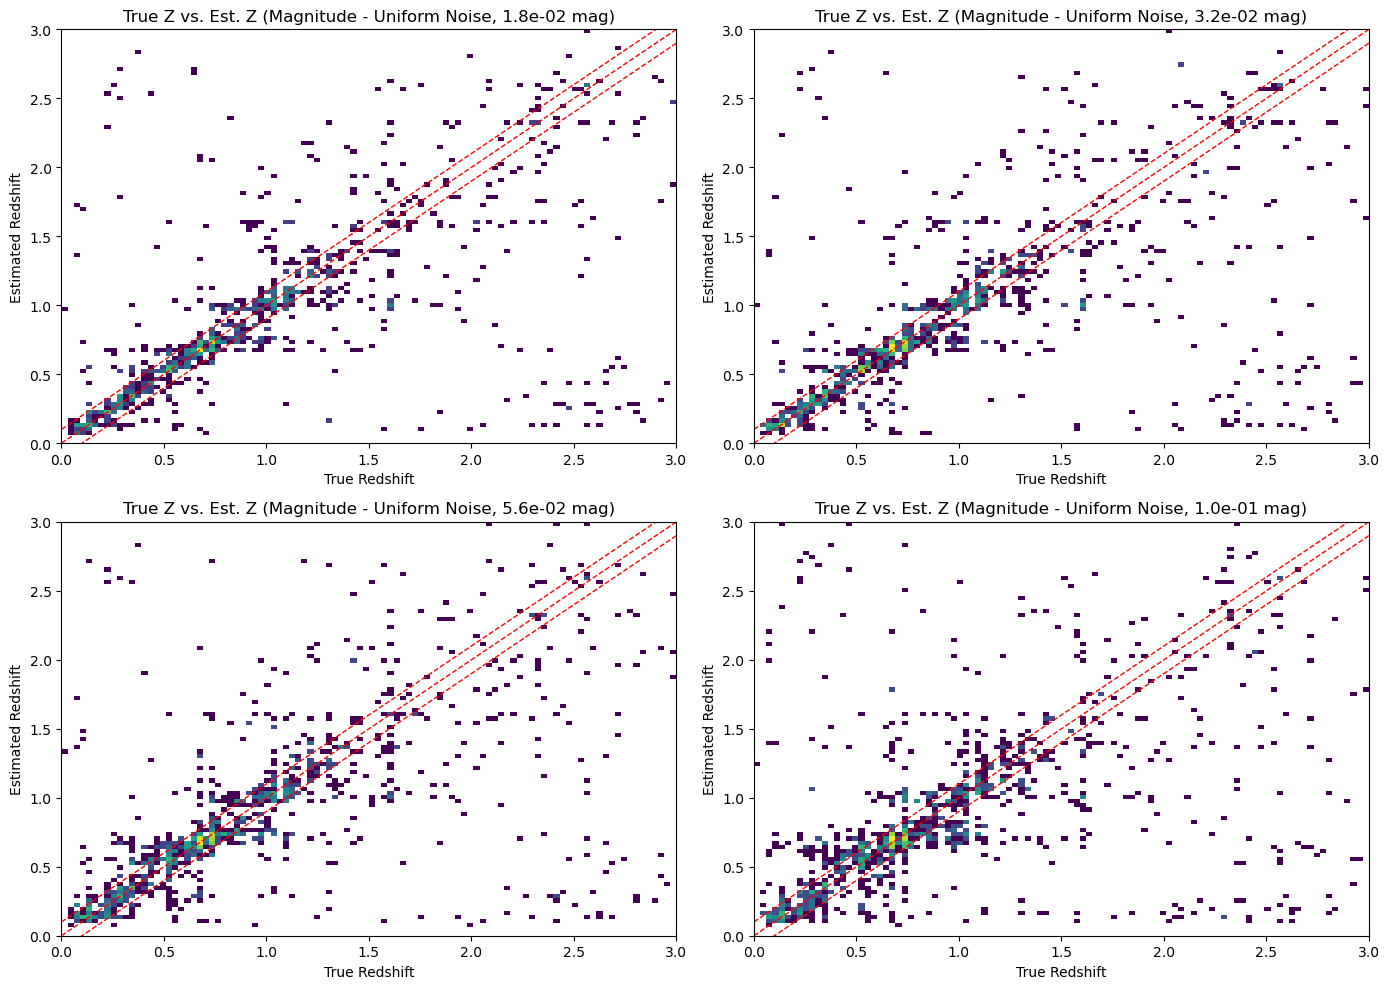

In [218]:
# astra ·₊✧ 02/2026 .⋆˚★ Create 2D histograms for magnitude_uniform models at selected noise levels

# Select 4 noise levels in the interesting region
selected_noise_levels = [0.01778279410038923, 0.03162277660168379, 0.05623413251903491, 0.1]

# Create subplot grid (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, noise in enumerate(selected_noise_levels):
    estimate = estimates['magnitude_uniform'][noise]
    
    # Extract redshifts
    z_est = np.squeeze(estimate.data.ancil['zmode'])
    z_true = estimate.data.ancil['redshift']
    
    # Create 2D histogram
    axes[idx].hist2d(z_true, z_est, 
                     bins=(np.linspace(0., 3, 101), np.linspace(0., 3, 101)), 
                     norm='log')
    
    # Add reference lines
    z_range = np.linspace(0, 3, 100)
    axes[idx].plot(z_range, z_range, 'r--', linewidth=1)
    axes[idx].plot(z_range, z_range + 0.1, 'r--', linewidth=1)
    axes[idx].plot(z_range, z_range - 0.1, 'r--', linewidth=1)
    
    axes[idx].set_ylabel('Estimated Redshift')
    axes[idx].set_xlabel('True Redshift')
    axes[idx].set_title(f'True Z vs. Est. Z (Magnitude - Uniform Noise, {noise:.1e} mag)')

plt.tight_layout()
plt.show()

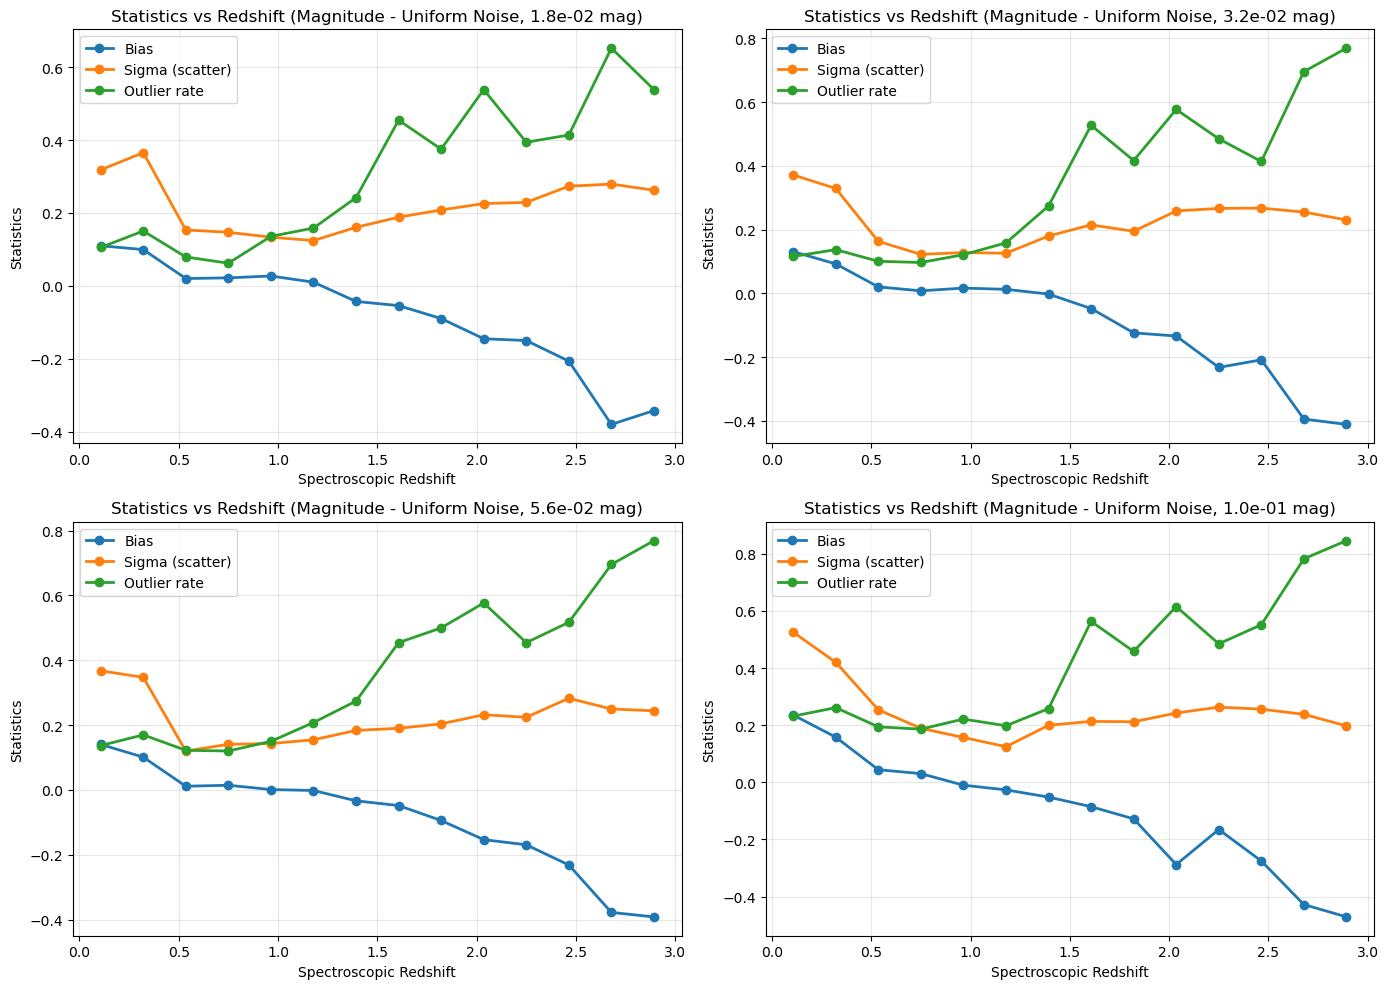

In [217]:
# astra ·₊✧ 02/2026 .⋆˚★ Calculate and plot statistics for magnitude_uniform models at selected noise levels

# Select 4 noise levels in the interesting region (exact values from noise_grid)
selected_noise_levels = [0.01778279410038923, 0.03162277660168379, 0.05623413251903491, 0.1]

# Create subplot grid (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

z_bins = np.linspace(0, 3, 15)  # 14 bins from 0 to 3

for idx, noise in enumerate(selected_noise_levels):
    estimate = estimates['magnitude_uniform'][noise]
    
    # Calculate metrics
    bin_centers, sigma, bias, outlier_rate = calc_photoz_performance_metrics(estimate, z_bins)
    
    # Plot statistics
    axes[idx].plot(bin_centers, bias, 'o-', label='Bias', linewidth=2)
    axes[idx].plot(bin_centers, sigma, 'o-', label='Sigma (scatter)', linewidth=2)
    axes[idx].plot(bin_centers, outlier_rate, 'o-', label='Outlier rate', linewidth=2)
    axes[idx].set_xlabel('Spectroscopic Redshift')
    axes[idx].set_ylabel('Statistics')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_title(f'Statistics vs Redshift (Magnitude - Uniform Noise, {noise:.1e} mag)')

plt.tight_layout()
plt.show()

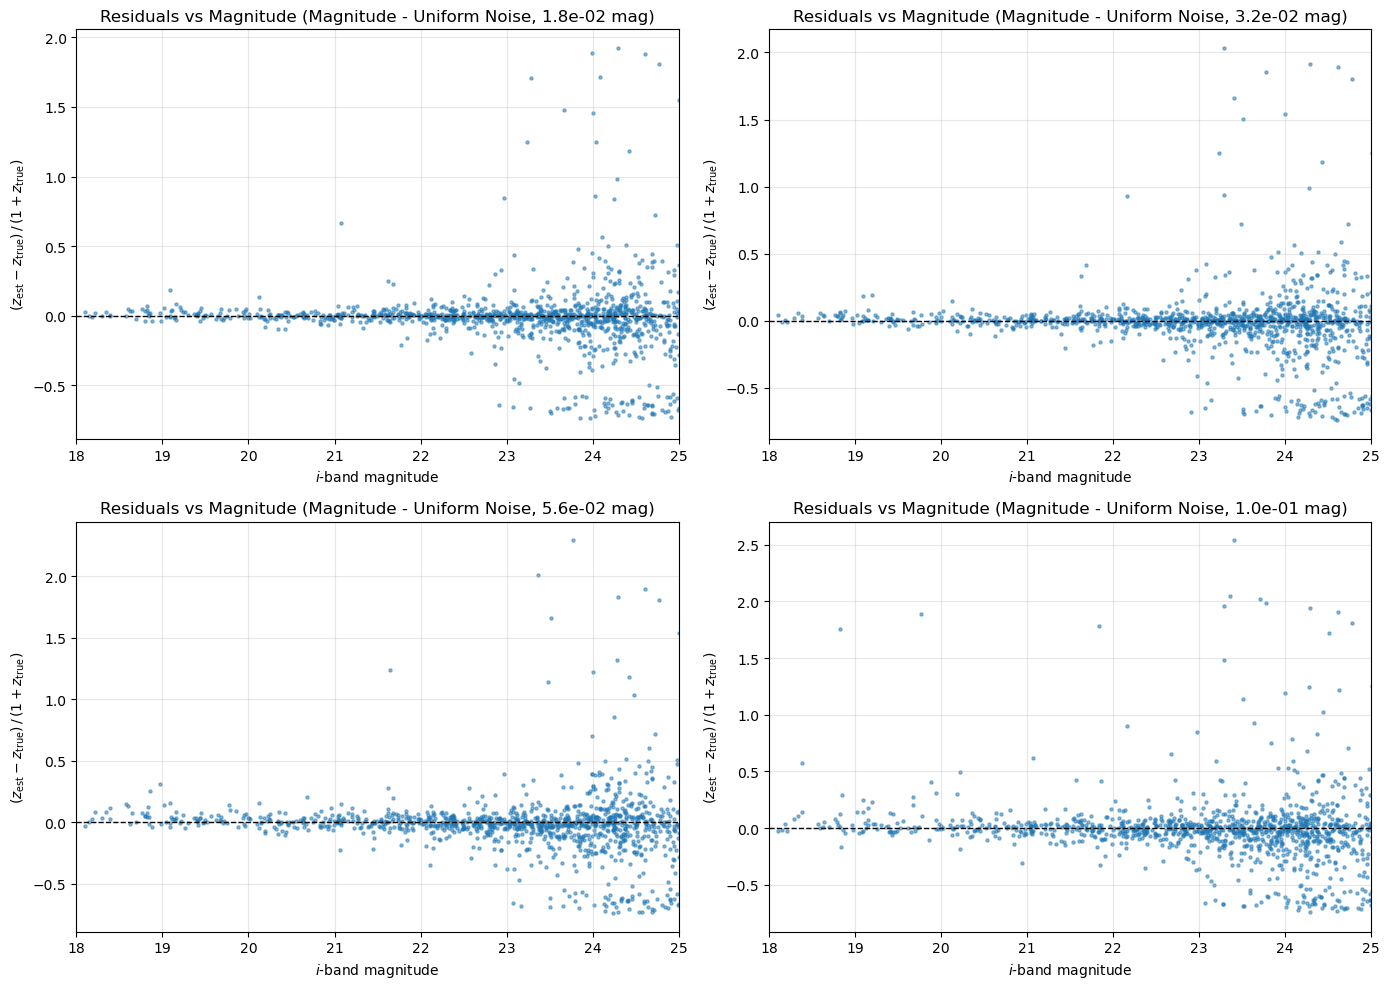

In [216]:
# astra ·₊✧ 02/2026 .⋆˚★ Create residual scatter plots for magnitude_uniform models at selected noise levels

# Select 4 noise levels in the interesting region (exact values from noise_grid)
selected_noise_levels = [0.01778279410038923, 0.03162277660168379, 0.05623413251903491, 0.1]

# Extract i-band magnitude from test data
i_mag = test['i_gaap1p0Mag']

# Create subplot grid (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, noise in enumerate(selected_noise_levels):
    estimate = estimates['magnitude_uniform'][noise]
    
    # Calculate normalized residuals
    z_est = estimate.data.ancil['zmode'].flatten()
    z_true = test['redshift']
    delta_z = (z_est - z_true) / (1 + z_true)
    
    # Create scatter plot
    axes[idx].scatter(i_mag, delta_z, alpha=0.5, s=5)
    axes[idx].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[idx].set_xlabel(r'$i$-band magnitude')
    axes[idx].set_ylabel(r'$(z_{\mathrm{est}} - z_{\mathrm{true}}) \, / \, (1 + z_{\mathrm{true}})$')
    axes[idx].set_title(f'Residuals vs Magnitude (Magnitude - Uniform Noise, {noise:.1e} mag)')
    axes[idx].set_xlim(18, 25)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Individual Plots

### Baseline

In [172]:
# Baseline ancillary data (summary statistics and metadata)
estimates['baseline'].data.ancil

{'distribution_type': array([0, 0, 0, ..., 0, 0, 0]),
 'redshift': array([0.44316, 0.33899, 0.21898, ..., 0.84497, 0.2893 , 0.26602]),
 'zmode': array([[0.48],
        [0.3 ],
        [0.22],
        ...,
        [0.75],
        [0.53],
        [0.28]])}

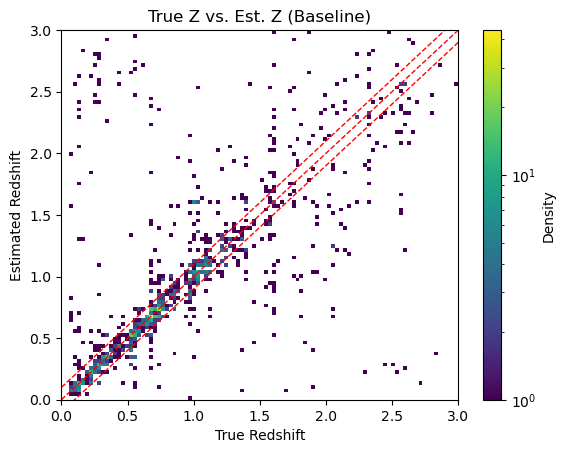

In [173]:
# Visualize baseline performance: z_true vs z_estimated
_ = plt.hist2d(
     np.squeeze(estimates['baseline'].data.ancil['zmode']),
    estimates['baseline'].data.ancil['redshift'],
    bins=(np.linspace(0.,3, 101), np.linspace(0.,3, 101)), norm='log',
)

z_range = np.linspace(0, 3, 100)
plt.plot(z_range, z_range, 'r--', linewidth=1)  # y=x
plt.plot(z_range, z_range + 0.1, 'r--', linewidth=1)  # +0.1
plt.plot(z_range, z_range - 0.1, 'r--', linewidth=1)  # -0.1
plt.colorbar(label='Density')
_ = plt.title('True Z vs. Est. Z (Baseline)')
_ = plt.xlabel("True Redshift")
_ = plt.ylabel("Estimated Redshift")

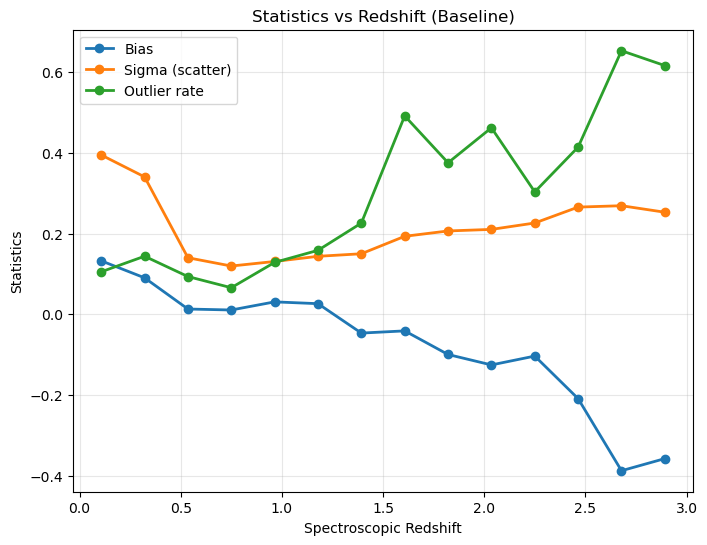

In [174]:
# astra ·₊✧ 01/2026 .⋆˚★ Calculate and plot statistics

z_bins = np.linspace(0, 3, 15)  # 14 bins from 0 to 3
bin_centers, sigma, bias, outlier_rate = calc_photoz_performance_metrics(estimates['baseline'], z_bins)

plt.figure(figsize=(8, 6))
plt.plot(bin_centers, bias, 'o-', label='Bias', linewidth=2)
plt.plot(bin_centers, sigma, 'o-', label='Sigma (scatter)', linewidth=2)
plt.plot(bin_centers, outlier_rate, 'o-', label='Outlier rate', linewidth=2)
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Statistics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Statistics vs Redshift (Baseline)')
plt.show()

### Magnitude Cases

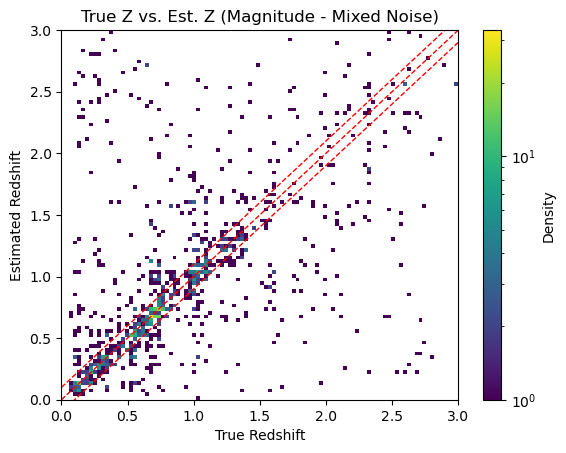

In [209]:
# astra ·₊✧ 01/2026 .⋆˚★ Visualize noisy performance: z_true vs z_estimated
_ = plt.hist2d(
     np.squeeze(estimates['magnitude_mixed'].data.ancil['zmode']),
    estimates['magnitude_mixed'].data.ancil['redshift'],
    bins=(np.linspace(0.,3, 101), np.linspace(0.,3, 101)), norm='log',
)

z_range = np.linspace(0, 3, 100)
plt.plot(z_range, z_range, 'r--', linewidth=1)  # y=x
plt.plot(z_range, z_range + 0.1, 'r--', linewidth=1)  # +0.1
plt.plot(z_range, z_range - 0.1, 'r--', linewidth=1)  # -0.1
plt.colorbar(label='Density')
_ = plt.title('True Z vs. Est. Z (Magnitude - Mixed Noise)')
_ = plt.xlabel("True Redshift")
_ = plt.ylabel("Estimated Redshift")

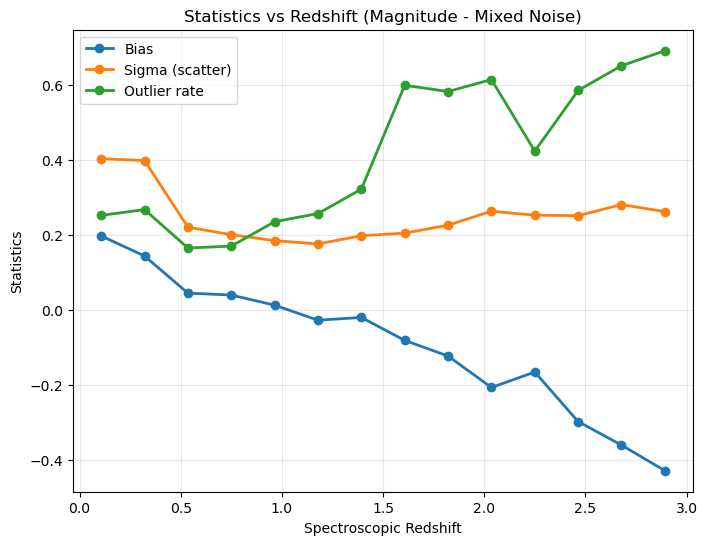

In [210]:
# astra ·₊✧ 02/2026 .⋆˚★ Calculate and plot statistics

z_bins = np.linspace(0, 3, 15)  # 14 bins from 0 to 3
bin_centers, sigma, bias, outlier_rate = calc_photoz_performance_metrics(estimates['magnitude_mixed'], z_bins)

plt.figure(figsize=(8, 6))
plt.plot(bin_centers, bias, 'o-', label='Bias', linewidth=2)
plt.plot(bin_centers, sigma, 'o-', label='Sigma (scatter)', linewidth=2)
plt.plot(bin_centers, outlier_rate, 'o-', label='Outlier rate', linewidth=2)
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Statistics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Statistics vs Redshift (Magnitude - Mixed Noise)')
plt.show()

### Redshift Cases

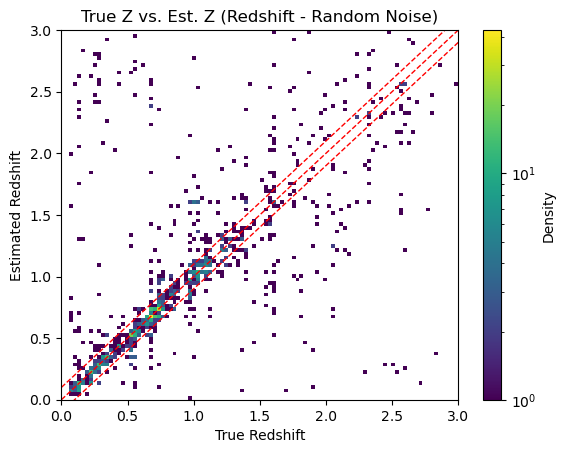

In [211]:
# astra ·₊✧ 01/2026 .⋆˚★ Visualize degraded performance: z_true vs z_estimated

_ = plt.hist2d(
     np.squeeze(estimates['redshift_random'].data.ancil['zmode']),
    estimates['redshift_random'].data.ancil['redshift'],
    bins=(np.linspace(0.,3, 101), np.linspace(0.,3, 101)), norm='log',
)

z_range = np.linspace(0, 3, 100)
plt.plot(z_range, z_range, 'r--', linewidth=1)  # y=x
plt.plot(z_range, z_range + 0.1, 'r--', linewidth=1)  # +0.1
plt.plot(z_range, z_range - 0.1, 'r--', linewidth=1)  # -0.1
plt.colorbar(label='Density')
_ = plt.title('True Z vs. Est. Z (Redshift - Random Noise)')
_ = plt.xlabel("True Redshift")
_ = plt.ylabel("Estimated Redshift")

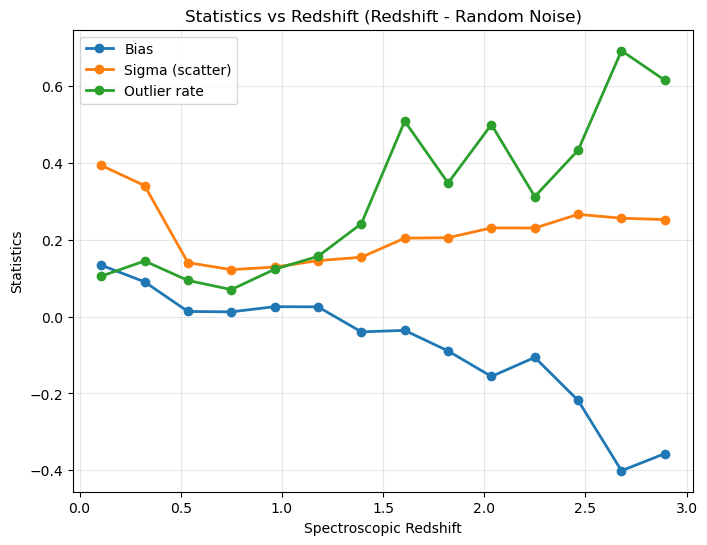

In [212]:
# astra ·₊✧ 02/2026 .⋆˚★ Calculate and plot statistics

z_bins = np.linspace(0, 3, 15)  # 14 bins from 0 to 3
bin_centers, sigma, bias, outlier_rate = calc_photoz_performance_metrics(estimates['redshift_random'], z_bins)
# but is this just taking the data for the last model trained? 

plt.figure(figsize=(8, 6))
plt.plot(bin_centers, bias, 'o-', label='Bias', linewidth=2)
plt.plot(bin_centers, sigma, 'o-', label='Sigma (scatter)', linewidth=2)
plt.plot(bin_centers, outlier_rate, 'o-', label='Outlier rate', linewidth=2)
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Statistics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Statistics vs Redshift (Redshift - Random Noise)')
plt.show()

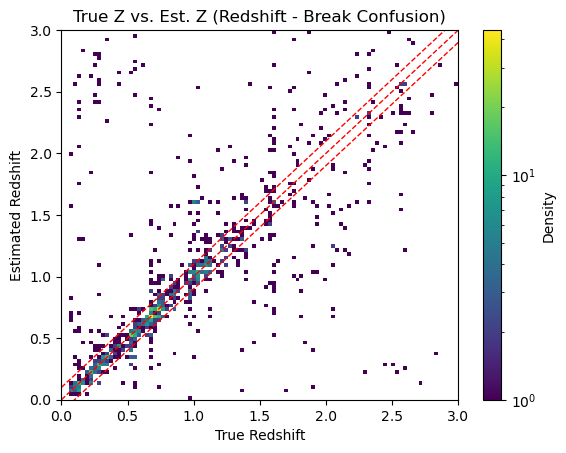

In [213]:
# astra ·₊✧ 01/2026 .⋆˚★ Visualize degraded performance: z_true vs z_estimated

_ = plt.hist2d(
     np.squeeze(estimates['redshift_break'].data.ancil['zmode']),
    estimates['redshift_break'].data.ancil['redshift'],
    bins=(np.linspace(0.,3, 101), np.linspace(0.,3, 101)), norm='log',
)

z_range = np.linspace(0, 3, 100)
plt.plot(z_range, z_range, 'r--', linewidth=1)  # y=x
plt.plot(z_range, z_range + 0.1, 'r--', linewidth=1)  # +0.1
plt.plot(z_range, z_range - 0.1, 'r--', linewidth=1)  # -0.1
plt.colorbar(label='Density')
_ = plt.title('True Z vs. Est. Z (Redshift - Break Confusion)')
_ = plt.xlabel("True Redshift")
_ = plt.ylabel("Estimated Redshift")

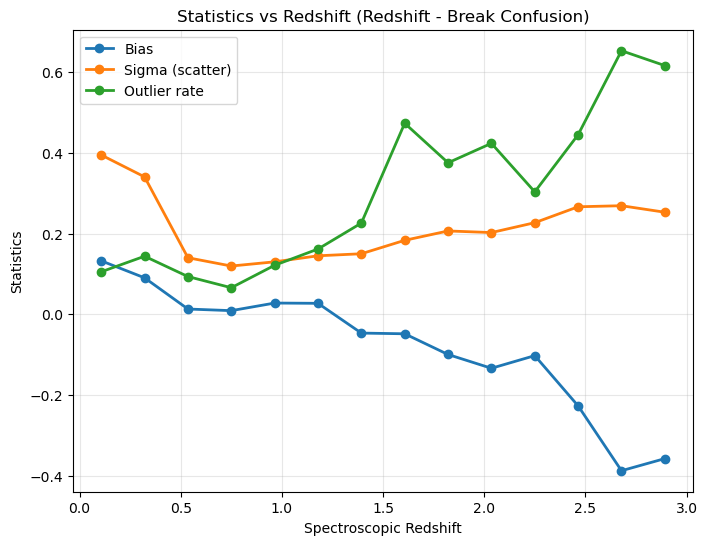

In [214]:
# astra ·₊✧ 02/2026 .⋆˚★ Calculate and plot statistics

z_bins = np.linspace(0, 3, 15)  # 14 bins from 0 to 3
bin_centers, sigma, bias, outlier_rate = calc_photoz_performance_metrics(estimates['redshift_break'], z_bins)
# but is this just taking the data for the last model trained? 

plt.figure(figsize=(8, 6))
plt.plot(bin_centers, bias, 'o-', label='Bias', linewidth=2)
plt.plot(bin_centers, sigma, 'o-', label='Sigma (scatter)', linewidth=2)
plt.plot(bin_centers, outlier_rate, 'o-', label='Outlier rate', linewidth=2)
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Statistics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Statistics vs Redshift (Redshift - Break Confusion)')
plt.show()

# Unused Code

## Debugging

In [58]:
# astra ·₊✧ 12/2025 .⋆˚★ Debugging: The data I train the model on differs, yet the output model is identical to baseline.
# What we know: 
#  - Training data going into inform is unique. 
#  - Original train dict is not degraded. 
#  - Model output files are identical by hash, even with extreme data 
#  - Inform is not loading old model files from disk because we're deleting them first

# Extreme test: degrade noisy training data so hyperparameters MUST differ

train_baseline = copy.deepcopy(train)
train_extreme = copy.deepcopy(train)
# shallow copies caused an issue once
#train_baseline = train.copy()
#train_extreme = train.copy()

# Make extreme dataset: add massive noise to force different hyperparameters
for band in 'ugrizy':
    train_extreme[f'u_gaap1p0Mag'] += 1000.0  
    train_extreme[f'g_gaap1p0Mag'] += 500.0   
    train_extreme[f'r_gaap1p0Mag'] += 333.0   

print(f"Baseline first u-mag: {train_baseline['u_gaap1p0Mag'][0]}")
print(f"Extreme first u-mag: {train_extreme['u_gaap1p0Mag'][0]}")

# Train both
uncertainties['baseline']_test, _ = train_test_uncertainty(
    train_baseline, test, z_grid,
    KNearNeighInformer, KNearNeighEstimator,
    informer_kwargs={'nondetect_val': np.nan},
    label='baseline_test'
)

uncertainty_extreme_test2, _ = train_test_uncertainty(
    train_extreme, test, z_grid,
    KNearNeighInformer, KNearNeighEstimator,
    informer_kwargs={'nondetect_val': np.nan},
    label='extreme_test2'
)

# Check hashes
import hashlib
with open('baseline_test_model.pkl', 'rb') as f:
    hash1 = hashlib.md5(f.read()).hexdigest()
with open('extreme_test2_model.pkl', 'rb') as f:
    hash2 = hashlib.md5(f.read()).hexdigest()
    
print(f"Baseline test hash: {hash1}")
print(f"Extreme test hash: {hash2}")
print(f"★ Still identical? {hash1 == hash2}")

Baseline first u-mag: 25.005736412107943
Extreme first u-mag: 6025.005736412108
Deleted existing baseline_test_model.pkl
Inserting handle into data store.  input: None, KNearNeighInformer
split into 3602 training and 1201 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.03166666666666667 and numneigh=7



Inserting handle into data store.  model: inprogress_baseline_test_model.pkl, KNearNeighInformer
Process 0 running estimator on chunk 0 - 1,201
Process 0 estimating PZ PDF for rows 0 - 1,201
Inserting handle into data store.  output: inprogress_baseline_test_output.hdf5, KNearNeighEstimator
Deleted existing extreme_test2_model.pkl
Inserting handle into data store.  input: None, KNearNeighInformer
split into 3602 training and 1201 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.03166666666666667 and numneigh=7



Inserting handle into data store.  model: inprogress_extreme_test2_model.pkl, KNearNeighInformer
P

In [64]:
# astra ·₊✧ 12/2025 .⋆˚★ Debugging: Verify models contain different data by checking file content hash
import hashlib
with open('baseline_model.pkl', 'rb') as f:
    baseline_hash = hashlib.md5(f.read()).hexdigest()
with open('noisy_model.pkl', 'rb') as f:
    noisy_hash = hashlib.md5(f.read()).hexdigest()
print(f"Baseline model hash: {baseline_hash}")
print(f"Noisy model hash: {noisy_hash}")
print(f"Models identical? {baseline_hash == noisy_hash}")

Baseline model hash: c256b295530ed14853406e2a6b431621
Noisy model hash: 5384143a6d900969fa6637fec7941092
Models identical? False


In [63]:
# astra ·₊✧ 12/2025 .⋆˚★ Debugging: More ways to check if models and outputs are actually different (from before I used file hashes)
# Check if any predictions differ at all
diff_count = (estimates['baseline'].data.ancil['zmode'] != estimate_noisy.data.ancil['zmode']).sum()
print(f"Number of different predictions: {diff_count} out of {len(estimates['baseline'].data.ancil['zmode'])}")

# Check uncertainty values
print(f"Baseline uncertainty median: {np.median(uncertainties['baseline']):.4f}")
print(f"Noisy uncertainty median: {np.median(uncertainty_noisy):.4f}")

NameError: name 'estimate_noisy' is not defined

In [46]:
# astra ·₊✧ 12/2025 .⋆˚★ Debugging identical model issue
print(f"estimates['baseline'] first 3 zmode: {estimates['baseline'].data.ancil['zmode'][:3]}")
print(f"estimate_noisy first 3 zmode: {estimate_noisy.data.ancil['zmode'][:3]}")
print(f"Are they identical? {np.array_equal(estimates['baseline'].data.ancil['zmode'], estimate_noisy.data.ancil['zmode'])}")
print(f"estimates['baseline'] path: {estimates['baseline'].path}")
print(f"estimate_noisy path: {estimate_noisy.path}")
print(f"Same file? {estimates['baseline'].path == estimate_noisy.path}")
print(f"Same object in memory? {estimates['baseline'] is estimate_noisy}")
# Check if .data loads fresh from disk each time
print("Accessing estimates['baseline'].data.ancil NOW (after noisy training):")
print(estimates['baseline'].data.ancil['zmode'][:3])
print(f"This reads from: {estimates['baseline'].path}")

estimate_baseline first 3 zmode: [[0.48]
 [0.3 ]
 [0.22]]
estimate_noisy first 3 zmode: [[0.48]
 [0.34]
 [0.32]]
Are they identical? False
estimate_baseline path: baseline_output.hdf5
estimate_noisy path: noisy_output.hdf5
Same file? False
Same object in memory? False
Accessing estimate_baseline.data.ancil NOW (after noisy training):
[[0.48]
 [0.3 ]
 [0.22]]
This reads from: baseline_output.hdf5


In [45]:
# astra ·₊✧ 12/2025 .⋆˚★ Debugging: Are the model files identical, and/or are they pointing to the same file?
print("Files matching *model.pkl:")
import glob
for f in glob.glob("*model.pkl"):
    print(f"  {f}: {os.path.getsize(f)} bytes")

print(f"baseline inode: {os.stat('baseline_model.pkl').st_ino}")
print(f"noisy inode: {os.stat('noisy_model.pkl').st_ino}")

Files matching *model.pkl:
  baseline_model.pkl: 327035 bytes
  noisy_model.pkl: 327001 bytes
  extreme_test2_model.pkl: 327035 bytes
  baseline_test_model.pkl: 327035 bytes
  extreme_test_model.pkl: 327035 bytes
baseline inode: 522229
noisy inode: 513975


## Visualization

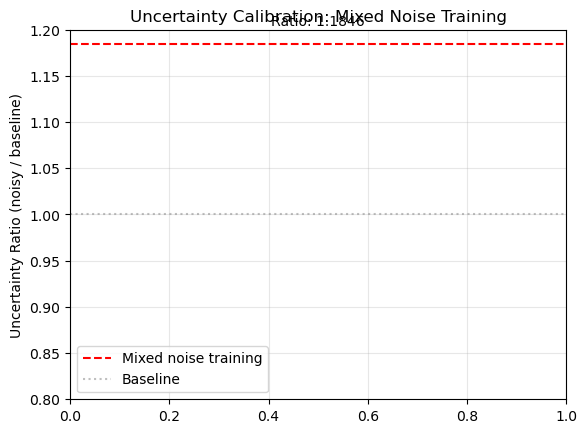

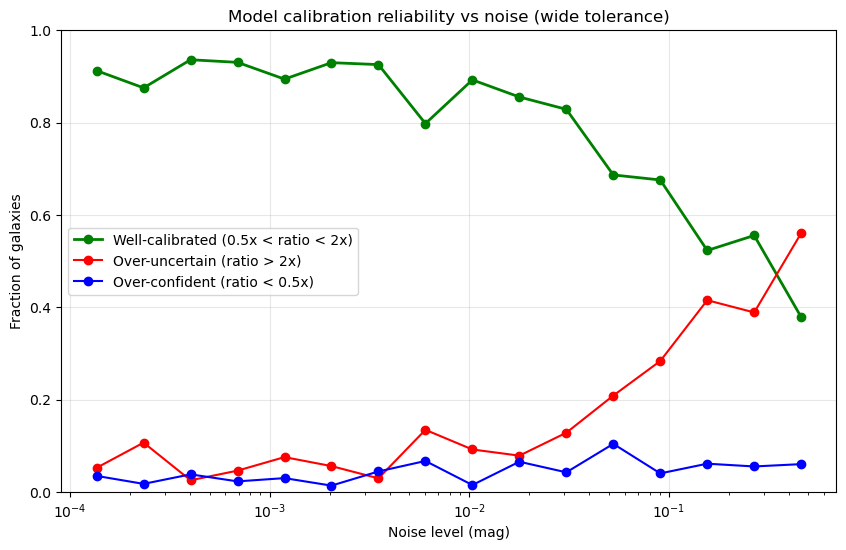


Noise bin populations:
  0.0001 mag: 57 galaxies
  0.0002 mag: 56 galaxies
  0.0004 mag: 78 galaxies
  0.0007 mag: 86 galaxies
  0.0012 mag: 66 galaxies
  0.0020 mag: 71 galaxies
  0.0035 mag: 67 galaxies
  0.0060 mag: 89 galaxies
  0.0104 mag: 65 galaxies
  0.0178 mag: 76 galaxies
  0.0306 mag: 70 galaxies
  0.0527 mag: 67 galaxies
  0.0906 mag: 74 galaxies
  0.1557 mag: 65 galaxies
  0.2676 mag: 72 galaxies
  0.4600 mag: 66 galaxies
  0.7909 mag: 0 galaxies
Uncertainty ratios: [np.float64(1.1846291430294218)]
Noise levels tested: ['mixed']
Current x-limits: (np.float64(0.0), np.float64(1.0))
Current y-limits: (np.float64(0.0), np.float64(1.0))


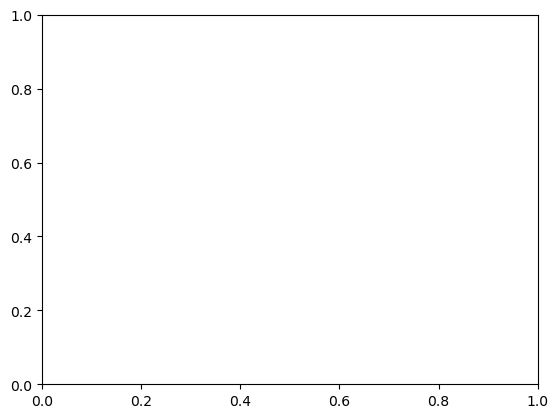

In [40]:
#  astra ·₊✧ 12/2025 .⋆˚★ ///// WORK IN PROGRESS ///// Visualize uncertainty calibration with noise

if TRAIN_ON_MIXED_NOISE:
    _ = plt.axhline(y=uncertainty_ratios[0], color='red', linestyle='--', label='Mixed noise training')
    _ = plt.text(0.5, uncertainty_ratios[0] + 0.02, f'Ratio: {uncertainty_ratios[0]:.4f}', ha='center')
    _ = plt.xlim(0, 1)
    _ = plt.title('Uncertainty Calibration: Mixed Noise Training')
else:
    _ = plt.plot(noise_levels_tested, uncertainty_ratios, 'o-', color='red', label='Uncertainty ratio')
    _ = plt.xscale('log')
    _ = plt.xlabel('Gaussian Noise Level (mag)')
    _ = plt.title('Uncertainty Calibration: Per-Level Training')

_ = plt.ylabel('Uncertainty Ratio (noisy / baseline)')
_ = plt.axhline(y=1.0, color='gray', linestyle=':', alpha=0.5, label='Baseline')
_ = plt.legend()
_ = plt.grid(True, alpha=0.3)
_ = plt.ylim(0.8, 1.2)
plt.show()# At what noise level does the model's uncertainty become unreliable?
# Strategy: For each noise bin, calculate fraction of galaxies with extreme uncertainty ratios

# Define noise bins
noise_bins = np.logspace(-4, 0, 18)
noise_bin_centers = (noise_bins[:-1] + noise_bins[1:]) / 2

# Define thresholds for "unreliable" uncertainty
# ratio > threshold means model is TOO uncertain (overestimating)
# ratio < 1/threshold means model is TOO confident (underestimating)
threshold = 2.0

fractions_overconfident = []
fractions_overuncertain = []
fractions_reasonable = []
n_galaxies_per_bin = []

for i in range(len(noise_bins) - 1):
    mask = (test_noise_levels >= noise_bins[i]) & (test_noise_levels < noise_bins[i+1])
    n_in_bin = mask.sum()
    n_galaxies_per_bin.append(n_in_bin)
    
    if n_in_bin > 0:
        ratios_in_bin = ratio_per_galaxy[mask]
        
        overconfident = (ratios_in_bin < 1.0/threshold).sum() / n_in_bin
        overuncertain = (ratios_in_bin > threshold).sum() / n_in_bin
        reasonable = ((ratios_in_bin >= 1.0/threshold) & (ratios_in_bin <= threshold)).sum() / n_in_bin
        
        fractions_overconfident.append(overconfident)
        fractions_overuncertain.append(overuncertain)
        fractions_reasonable.append(reasonable)
    else:
        fractions_overconfident.append(np.nan)
        fractions_overuncertain.append(np.nan)
        fractions_reasonable.append(np.nan)

plt.figure(figsize=(10, 6))
plt.plot(noise_bin_centers, fractions_reasonable, 'g-o', label='Well-calibrated (0.5x < ratio < 2x)', linewidth=2)
plt.plot(noise_bin_centers, fractions_overuncertain, 'r-o', label='Over-uncertain (ratio > 2x)')
plt.plot(noise_bin_centers, fractions_overconfident, 'b-o', label='Over-confident (ratio < 0.5x)')
plt.xscale('log')
plt.xlabel('Noise level (mag)')
plt.ylabel('Fraction of galaxies')
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('Model calibration reliability vs noise (wide tolerance)')
plt.ylim(0, 1)
plt.show()

print("\nNoise bin populations:")
for i, (center, n) in enumerate(zip(noise_bin_centers, n_galaxies_per_bin)):
    print(f"  {center:.4f} mag: {n} galaxies")
print(f"Uncertainty ratios: {uncertainty_ratios}")
print(f"Noise levels tested: {noise_levels_tested}")
print(f"Current x-limits: {plt.xlim()}")
print(f"Current y-limits: {plt.ylim()}")

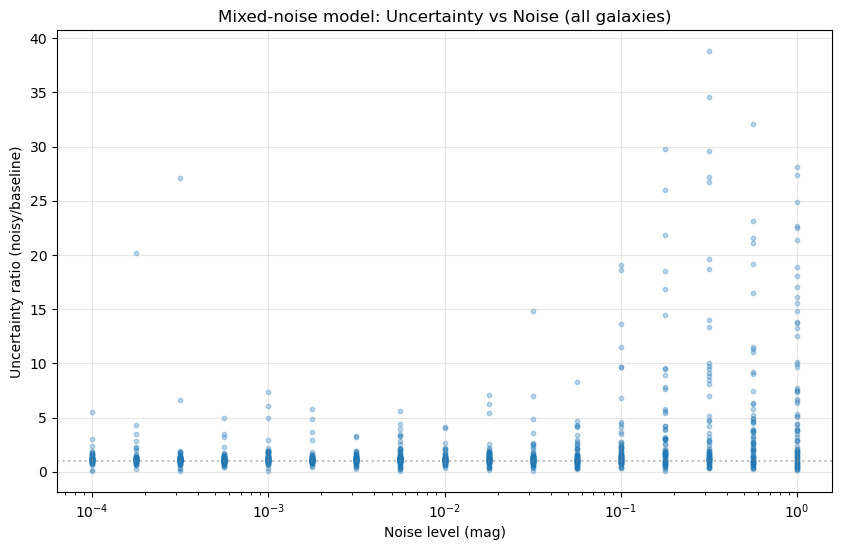

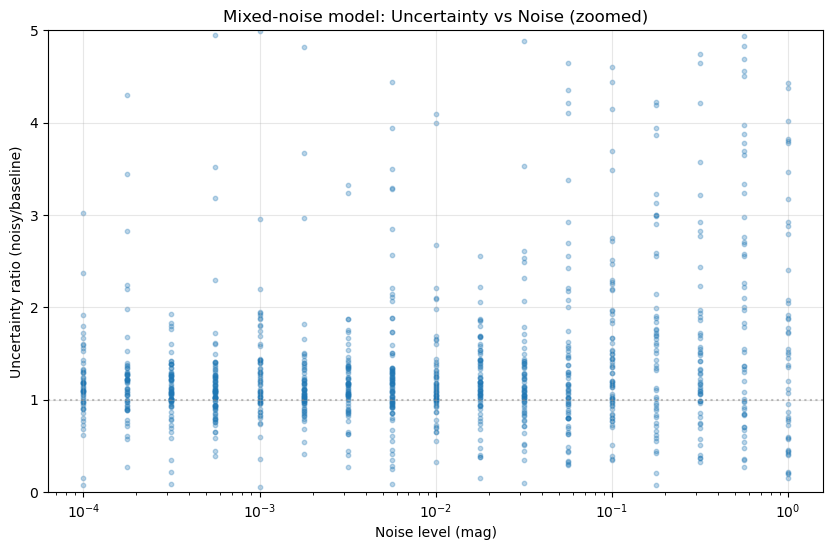

In [34]:
# astra ·₊✧ 12/2025 .⋆˚★ Plot uncertainty vs noise for mixed-noise model (all galaxies)
ratio_per_galaxy = uncertainty_noisy / uncertainties['baseline']
plt.figure(figsize=(10, 6))
plt.scatter(test_noise_levels, ratio_per_galaxy, alpha=0.3, s=10)
plt.xscale('log')
plt.xlabel('Noise level (mag)')
plt.ylabel('Uncertainty ratio (noisy/baseline)')
plt.axhline(y=1.0, color='gray', linestyle=':', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.title('Mixed-noise model: Uncertainty vs Noise (all galaxies)')
plt.show()

# Zoomed plot focusing on ratio 0-5 range
plt.figure(figsize=(10, 6))
plt.scatter(test_noise_levels, ratio_per_galaxy, alpha=0.3, s=10)
plt.xscale('log')
plt.xlabel('Noise level (mag)')
plt.ylabel('Uncertainty ratio (noisy/baseline)')
plt.axhline(y=1.0, color='gray', linestyle=':', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.ylim(0, 5)
plt.title('Mixed-noise model: Uncertainty vs Noise (zoomed)')
plt.show()

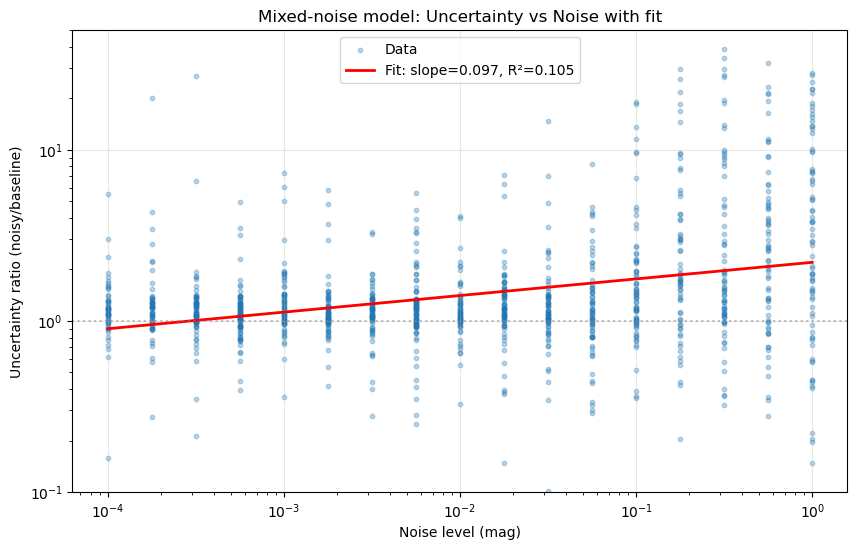

Slope: 0.0970
Interpretation: 10x noise increase → 1.25x uncertainty increase
R²: 0.1051


In [35]:
# astra ·₊✧ 12/2025 .⋆˚★ 
from scipy import stats

x_data = np.log10(test_noise_levels.flatten())
y_data = np.log10(ratio_per_galaxy.flatten())

slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)

x_fit = np.linspace(x_data.min(), x_data.max(), 100)
y_fit = slope * x_fit + intercept

plt.figure(figsize=(10, 6))
plt.scatter(test_noise_levels, ratio_per_galaxy, alpha=0.3, s=10, label='Data')
plt.plot(10**x_fit, 10**y_fit, 'r-', linewidth=2, label=f'Fit: slope={slope:.3f}, R²={r_value**2:.3f}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Noise level (mag)')
plt.ylabel('Uncertainty ratio (noisy/baseline)')
plt.axhline(y=1.0, color='gray', linestyle=':', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('Mixed-noise model: Uncertainty vs Noise with fit')
plt.ylim(0.1, 50)
plt.show()

print(f"Slope: {slope:.4f}")
print(f"Interpretation: 10x noise increase → {10**slope:.2f}x uncertainty increase")
print(f"R²: {r_value**2:.4f}")

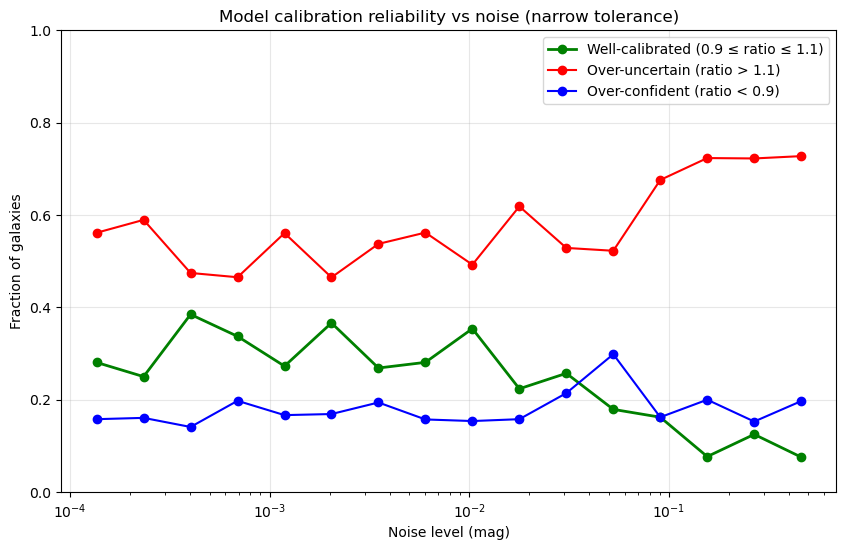


Noise bin populations:
  0.0001 mag: 57 galaxies
  0.0002 mag: 56 galaxies
  0.0004 mag: 78 galaxies
  0.0007 mag: 86 galaxies
  0.0012 mag: 66 galaxies
  0.0020 mag: 71 galaxies
  0.0035 mag: 67 galaxies
  0.0060 mag: 89 galaxies
  0.0104 mag: 65 galaxies
  0.0178 mag: 76 galaxies
  0.0306 mag: 70 galaxies
  0.0527 mag: 67 galaxies
  0.0906 mag: 74 galaxies
  0.1557 mag: 65 galaxies
  0.2676 mag: 72 galaxies
  0.4600 mag: 66 galaxies
  0.7909 mag: 0 galaxies


In [41]:
# astra ·₊✧ 12/2025 .⋆˚★ At what noise level does the model's uncertainty become unreliable?
# Strategy: For each noise bin, calculate fraction of galaxies with extreme uncertainty ratios

# Define noise bins
noise_bins = np.logspace(-4, 0, 18)
noise_bin_centers = (noise_bins[:-1] + noise_bins[1:]) / 2

# Define thresholds for "unreliable" uncertainty
# ratio > threshold means model is TOO uncertain (overestimating)
# ratio < 1/threshold means model is TOO confident (underestimating)
threshold_low = 0.9
threshold_high = 1.1

fractions_overconfident = []
fractions_overuncertain = []
fractions_reasonable = []
n_galaxies_per_bin = []

for i in range(len(noise_bins) - 1):
    mask = (test_noise_levels >= noise_bins[i]) & (test_noise_levels < noise_bins[i+1])
    n_in_bin = mask.sum()
    n_galaxies_per_bin.append(n_in_bin)
    
    if n_in_bin > 0:
        ratios_in_bin = ratio_per_galaxy[mask]
        
        overconfident = (ratios_in_bin < threshold_low).sum() / n_in_bin
        overuncertain = (ratios_in_bin > threshold_high).sum() / n_in_bin
        reasonable = ((ratios_in_bin >= threshold_low) & (ratios_in_bin <= threshold_high)).sum() / n_in_bin
        
        fractions_overconfident.append(overconfident)
        fractions_overuncertain.append(overuncertain)
        fractions_reasonable.append(reasonable)
    else:
        fractions_overconfident.append(np.nan)
        fractions_overuncertain.append(np.nan)
        fractions_reasonable.append(np.nan)

plt.figure(figsize=(10, 6))
plt.plot(noise_bin_centers, fractions_reasonable, 'g-o', label='Well-calibrated (0.9 ≤ ratio ≤ 1.1)', linewidth=2)
plt.plot(noise_bin_centers, fractions_overuncertain, 'r-o', label='Over-uncertain (ratio > 1.1)')
plt.plot(noise_bin_centers, fractions_overconfident, 'b-o', label='Over-confident (ratio < 0.9)')
plt.xscale('log')
plt.xlabel('Noise level (mag)')
plt.ylabel('Fraction of galaxies')
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('Model calibration reliability vs noise (narrow tolerance)')
plt.ylim(0, 1)
plt.show()

print("\nNoise bin populations:")
for i, (center, n) in enumerate(zip(noise_bin_centers, n_galaxies_per_bin)):
    print(f"  {center:.4f} mag: {n} galaxies")

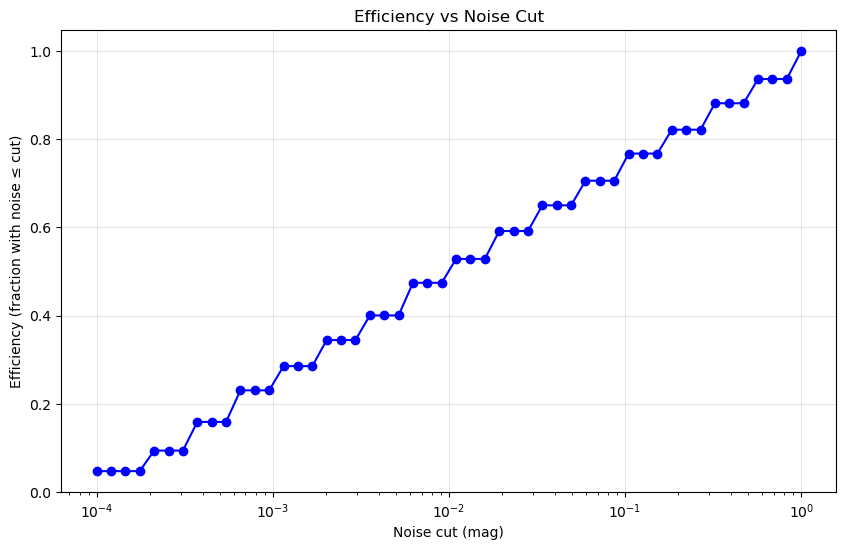

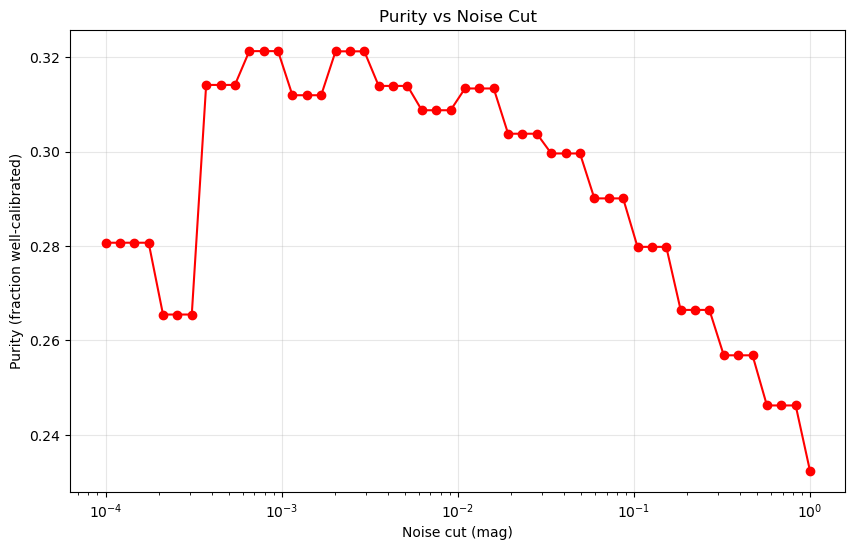

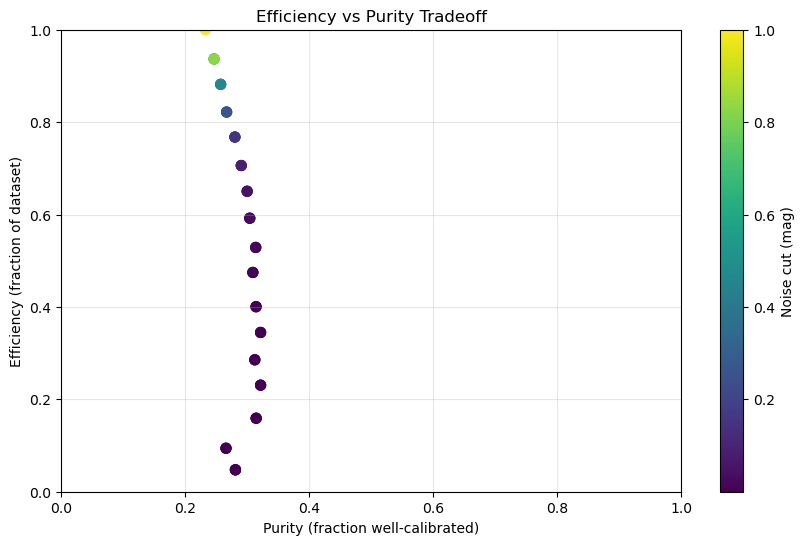

In [37]:
# astra ·₊✧ 12/2025 .⋆˚★ Replicate efficiency vs purity for uncertainty calibration

# Define cuts on noise level to scan
noise_cuts = np.logspace(-4, 0, 50)

efficiencies = []
purities = []

for noise_cut in noise_cuts:
    # Efficiency: fraction of test set with noise below cut
    mask_pass = test_noise_levels <= noise_cut
    efficiency = mask_pass.sum() / len(test_noise_levels)
    
    # Purity: of those passing, fraction with well-calibrated uncertainty
    if mask_pass.sum() > 0:
        ratios_passing = ratio_per_galaxy[mask_pass]
        well_calibrated = ((ratios_passing >= threshold_low) & (ratios_passing <= threshold_high)).sum()
        purity = well_calibrated / mask_pass.sum()
    else:
        purity = np.nan
    
    efficiencies.append(efficiency)
    purities.append(purity)

efficiencies = np.array(efficiencies)
purities = np.array(purities)

# Plot 1: Efficiency vs noise cut
plt.figure(figsize=(10, 6))
plt.plot(noise_cuts, efficiencies, 'b-o')
plt.xscale('log')
plt.xlabel('Noise cut (mag)')
plt.ylabel('Efficiency (fraction with noise ≤ cut)')
plt.grid(True, alpha=0.3)
plt.title('Efficiency vs Noise Cut')
plt.show()

# Plot 2: Purity vs noise cut
plt.figure(figsize=(10, 6))
plt.plot(noise_cuts, purities, 'r-o')
plt.xscale('log')
plt.xlabel('Noise cut (mag)')
plt.ylabel('Purity (fraction well-calibrated)')
plt.grid(True, alpha=0.3)
plt.title('Purity vs Noise Cut')
plt.show()

# Plot 3: Efficiency vs Purity (the tradeoff curve)
plt.figure(figsize=(10, 6))
plt.scatter(purities, efficiencies, c=noise_cuts, cmap='viridis', s=50)
plt.xlabel('Purity (fraction well-calibrated)')
plt.ylabel('Efficiency (fraction of dataset)')
plt.colorbar(label='Noise cut (mag)')
plt.grid(True, alpha=0.3)
plt.title('Efficiency vs Purity Tradeoff')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()